In [1]:
# Uncomment the commented-out lines in this cell when generating ELMo embeddings to avoid excess warning messages.
import gc
import glob
import functools
import operator
import itertools
from sacremoses import MosesTokenizer  # For ELMo preprocessing
import matplotlib.pyplot as plt
# import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
# tf.get_logger().setLevel('ERROR')
# tf.logging.set_verbosity(tf.logging.ERROR)
# tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import tensorflow_hub as hub
from sklearn.pipeline import *
from sklearn.preprocessing import *
from sklearn.decomposition import *
from sklearn.feature_selection import *
from Models import *

In [2]:
fs = glob.glob(data_dir + wiki_dir + "*.jsonl")
elmo_tokenizer = MosesTokenizer()  # Tokenise in the same way as ELMo's original training
transl_elmo = lambda s: ' '.join(elmo_tokenizer.tokenize(s, escape=False)).replace(" ' s ", " 's ").replace("-LSB-", "["). \
    replace("-RSB-", "]")

In [3]:
transl_elmo("From 1985―2015 Coster-Waldau"), transl_elmo("From 1985-2015 Coster-Waldau")  # Leaves the dashes alone

('From 1985 ― 2015 Coster-Waldau', 'From 1985-2015 Coster-Waldau')

In [4]:
claims, claims_vocab = load_claims(n=1000, test_10=False)  # Load 1000 training claims
claims_dev, claims_vocab_dev = load_claims(dev=True)
claims += claims_dev
claims_vocab |= claims_vocab_dev
N_claims = len(claims)
print(N_claims, len(claims_vocab), [c["id"] for c in claims[-10:]])

1010 3119 [137334, 111897, 89891, 181634, 219028, 108281, 204361, 54168, 105095, 18708]


In [ ]:
# Load documents as term frequencies and total word counts
tfs, wiki, n_t = load_docs(fs, claims_vocab, load_tf=True)

In [20]:
save_ld((tfs, wiki, n_t), "loaded_docs_1000c+d")  # 1010 claims total

In [5]:
tfs, wiki, n_t = load_ld("loaded_docs_1000c+d")

In [21]:
D_ids = list(wiki.keys())
tdist = sorted([(a, b) for (b, a) in list(tfs.items())])[::-1]      # Term freqeuency distribution
y = [t[0] for t in tdist]
N_docs = len(wiki)                                                  # Number of documents
N = len(y)                                                          # Number of unique terms
mean_doc_len = np.mean([wiki[id_][1] for id_ in wiki])
words_total = sum(tfs.values())
c_M = {w: tfs[w] / words_total for w in tfs}
N_docs, N, mean_doc_len, words_total, c_M["the"], c_M["of"]

(5396101,
 5174471,
 117.62701346768714,
 634727245,
 0.0421404882344384,
 0.03353797267675188)

In [22]:
# Adjust variables to implement smooth IDF and smoothed Jelinik-Mercer/Dirichlet smoothing (assume that words found only in
# the query claim, and not in the wikipedia pages, occur once in the wikipedia pages, in one existing new document)
changed = False
for w in claims_vocab:
    if w not in n_t:
        n_t[w] = 0
        tfs[w] = 1
        N += 1
        changed = True
if changed:
    words_total = sum(tfs.values())
    c_M = {w: tfs[w] / words_total for w in tfs}

In [8]:
cbi = 9
claims, claims_vocab = load_claims(n=100, offs=cbi * 100, test_10=False)     # Load training claims batch
for d_id in wiki:
    wiki[d_id] = ({w: wiki[d_id][0][w] for w in claims_vocab if w in wiki[d_id][0]}, wiki[d_id][1])     # Use memory efficiently
N_claims = len(claims)
gc.collect(), N_claims

(0, 100)

In [33]:
# Define document models
def lidstone_ll(doc_tf, total, epsilon=0.05, claims_=[]):
    zero_count_prob = epsilon / (total + (epsilon * N))
    doc_M = {w: ( (doc_tf[w] + epsilon) / (total + (epsilon * N)) ) for w in doc_tf if doc_tf[w] >= 1}
    return [np.sum(np.log([doc_M[w] if w in doc_M else zero_count_prob for w in claim["vocab"]])) for claim in claims_]
def dirichlet_ll(doc_tf, total, mu=mean_doc_len * 30.0, claims_=[]):
    doc_M_weight = (total / (total + mu))
    c_M_weight   = (mu    / (total + mu))
    doc_M = {w: ( (doc_M_weight * (doc_tf[w] if w in doc_tf else 0) / total) + \
                    (c_M_weight * c_M[w]) ) for w in claims_vocab}
    return [np.sum(np.log([doc_M[w] for w in claim["vocab"]])) for claim in claims_]
def eval_model(sim_func, **ps):
    batch_size = 10000
    D_batches = [D_ids[i * batch_size:(i + 1) * batch_size] for i in range((N_docs // batch_size) + 1)]
    print("Computing similarities (" + str(len(D_ids)) + " in " + str(len(D_batches)) + " batches)...")
    similarities = sum(joblib.Parallel(n_jobs=n_cpu, verbose=5)(delayed(batch_sims)(
        [wiki[doc_id] for doc_id in D_batch], sim_func, **ps) for D_batch in D_batches), [])
    sys_print("Ranking documents...")
    top_docs = []
    for i in range(N_claims):
        sims = np.asarray([similarities[j][i] for j in range(N_docs)])
        ord_ = np.argsort(sims)
        top_docs.append([D_ids[j] for j in ord_[-1000:]])
        sys_print("\rRanking documents... " + str(i + 1) + '/' + str(N_claims) + ' ')
    print("Evaluating accuracy...")
    res = eval_acc(top_docs, claims)
    return res, top_docs

In [10]:
accs, top_docs = eval_model(dirichlet_ll, claims_=claims)  # Get documents using Dirichlet retrieval
pr(accs)
save_json((accs, top_docs), "topdocs_dirichlet_ll_100c_" + str(cbi) + ".json", pad=False)

Computing similarities (5396101 in 540 batches)...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:   54.4s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:  4.3min
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed: 10.9min
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed: 19.6min
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed: 30.9min
[Parallel(n_jobs=8)]: Done 540 out of 540 | elapsed: 38.6min finished


Ranking documents... 100/100 Evaluating accuracy...
 Scoring evidence retrieval...
0.65 0.6666666666666665 0.6738095238095239 0.6711711711711712 0.14799999999999996 0.1333333333333333 0.13476190476190475 0.298 0.24110275689223049 0.22222222222222218 0.2246031746031746 0.4127423822714681
(   0.65,
    0.6666666666666665,
    0.6738095238095239,
    0.6711711711711712,
    0.14799999999999996,
    0.1333333333333333,
    0.13476190476190475,
    0.298,
    0.24110275689223049,
    0.22222222222222218,
    0.2246031746031746,
    0.4127423822714681)


In [14]:
# Assemble batched results
top_docs = []
for i in range(10):
    _, tds = load_json("topdocs_dirichlet_ll_100c_" + str(i) + ".json", pad=False)
    top_docs += tds
claims, claims_vocab = load_claims(n=1000, offs=0, test_10=False)  # Load 1000 training claims
N_claims = len(claims)
eval_acc(top_docs, claims)
len(top_docs)

 Scoring evidence retrieval...
0.557 0.5744023809523809 0.45022395607571153 0.4260869565217391 0.1286 0.11488047619047619 0.0900447912151423 0.2254 0.20895624270711782 0.1914674603174603 0.15007465202523718 0.29483322432962716


1000

In [38]:
k_scores = np.asarray([list(eval_acc(top_docs, claims, n=n, verbose=False)) for n in range(1, 500)])

<Figure size 432x288 with 0 Axes>

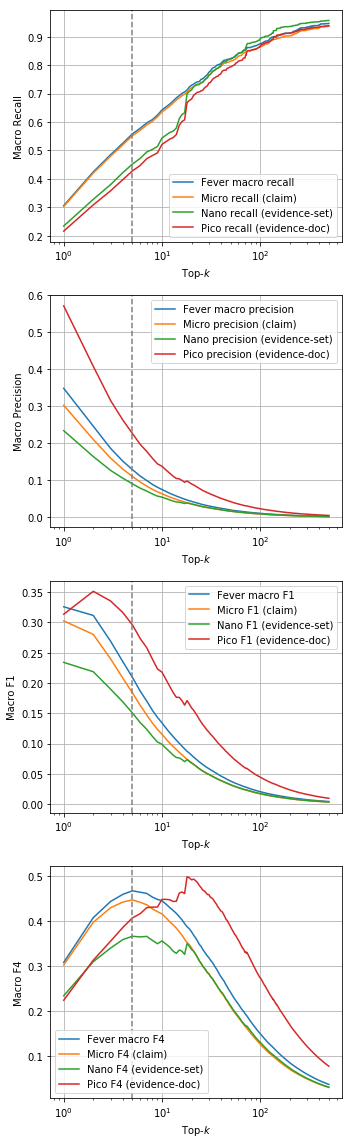

In [45]:
plt.clf()
fig = plt.figure()
fig.set_size_inches(5, 16)
fig.add_subplot(4, 1, 1)
plt.plot(range(1, 500), k_scores[:500, 0], label="Fever macro recall")
plt.plot(range(1, 500), k_scores[:500, 1], label="Micro recall (claim)")
plt.plot(range(1, 500), k_scores[:500, 2], label="Nano recall (evidence-set)")
plt.plot(range(1, 500), k_scores[:500, 3], label="Pico recall (evidence-doc)")
plt.axvline(x=5, color='grey', ls='--')
plt.legend()
plt.xscale('log')
plt.xlabel("Top-$k$")
plt.ylabel("Macro Recall")
plt.grid()
fig.add_subplot(4, 1, 2)
plt.plot(range(1, 500), k_scores[:500, 4 + 0], label="Fever macro precision")
plt.plot(range(1, 500), k_scores[:500, 4 + 1], label="Micro precision (claim)")
plt.plot(range(1, 500), k_scores[:500, 4 + 2], label="Nano precision (evidence-set)")
plt.plot(range(1, 500), k_scores[:500, 4 + 3], label="Pico precision (evidence-doc)")
plt.axvline(x=5, color='grey', ls='--')
plt.legend()
plt.xscale('log')
plt.xlabel("Top-$k$")
plt.ylabel("Macro Precision")
plt.grid()
fig.add_subplot(4, 1, 3)
plt.plot(range(1, 500), k_scores[:500, 8 + 0], label="Fever macro F1")
plt.plot(range(1, 500), k_scores[:500, 8 + 1], label="Micro F1 (claim)")
plt.plot(range(1, 500), k_scores[:500, 8 + 2], label="Nano F1 (evidence-set)")
plt.plot(range(1, 500), k_scores[:500, 8 + 3], label="Pico F1 (evidence-doc)")
plt.axvline(x=5, color='grey', ls='--')
plt.legend()
plt.xscale('log')
plt.xlabel("Top-$k$")
plt.ylabel("Macro F1")
plt.grid()
fig.add_subplot(4, 1, 4)
f_n = 4
plt.plot(range(1,500),weighted_harmonica(k_scores[:,4+0],k_scores[:,0], beta=f_n), label="Fever macro F" + str(f_n))
plt.plot(range(1,500),weighted_harmonica(k_scores[:,4+1],k_scores[:,1], beta=f_n), label="Micro F"+str(f_n)+" (claim)")
plt.plot(range(1,500),weighted_harmonica(k_scores[:,4+2],k_scores[:,2], beta=f_n), label="Nano F"+str(f_n)+" (evidence-set)")
plt.plot(range(1,500),weighted_harmonica(k_scores[:,4+3],k_scores[:,3], beta=f_n), label="Pico F"+str(f_n)+" (evidence-doc)")
plt.axvline(x=5, color='grey', ls='--')
plt.legend()
plt.xscale('log')
plt.xlabel("Top-$k$")
plt.ylabel("Macro F" + str(f_n))
plt.grid()
plt.tight_layout()
plt.savefig("graphs/performance_vs_k.pdf", filetype="pdf")
plt.show()

In [19]:
# Free memory of variables no longer needed
del wiki, tfs, D_ids, tdist, y

In [27]:
# save_json(top_docs, "topdocs_dirichlet_1000c.json", pad=False)
top_docs = load_json("topdocs_dirichlet_1000c.json", pad=False)
len(top_docs), len(claims)

(1000, 1010)

In [32]:
claims, claims_vocab = load_claims(dev=True)  # Load development set claims for Q4 (after this cell redefine likelihood models)
N_claims = len(claims)

In [73]:
accs_dev, top_docs_dev = eval_model(dirichlet_ll, claims_=claims)  # Retrieve test set documents
save_json((accs_dev, top_docs_dev), "topdocs_dirichlet_ll_10dev.json", pad=False)
len(top_docs_dev)

Computing similarities (5396101 in 540 batches)...


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:   30.8s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:  1.4min
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:  3.0min
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:  5.9min
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed: 10.0min
[Parallel(n_jobs=8)]: Done 540 out of 540 | elapsed: 12.2min finished


Ranking documents... 10/10 Evaluating accuracy...
 Scoring evidence retrieval...
0.4 0.4 0.43478260869565216 0.44 0.1 0.08 0.08695652173913043 0.22 0.16 0.13333333333333333 0.14492753623188406 0.29333333333333333


10

In [ ]:
top_docs += top_docs_dev  # Assemble document sets

In [225]:
claims, claims_vocab = load_claims(n=1000, test_10=False)  # Load 1000 training claims
claims_dev, claims_vocab_dev = load_claims(dev=True)
claims += claims_dev
claims_vocab |= claims_vocab_dev
N_claims = len(claims)
N_claims, len(top_docs)

(1010, 1010)

In [5]:
# save_json(top_docs, "topdocs_dirichlet_1010c+d.json", pad=False)
top_docs = load_json("topdocs_dirichlet_1010c+d.json", pad=False)
len(top_docs), len(claims)

(1010, 1010)

In [6]:
elmo = hub.Module("https://tfhub.dev/google/elmo/3", trainable=True)  # Load ELMo

# just a random sentence 
x = ["The quick brown fox",
     "The quick brown fox jumped",
     "The quick brown fox jumped over",
     "Random test sentence without any relevance",
     "The quick brown fox jumped over the lazy dog",]

# Extract ELMo features 
embeddings = elmo(x, signature="default", as_dict=True)["elmo"]
embeddings.shape

TensorShape([Dimension(5), Dimension(9), Dimension(1024)])

In [7]:
def elmo_vectors(x, key='elmo'):
    embeddings = elmo(x, signature="default", as_dict=True)[key]
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        sess.run(tf.tables_initializer())
        return sess.run(embeddings)
v = elmo_vectors(x, key='elmo')          # Test ELMo
v_ = elmo_vectors(x)
w = elmo_vectors(x, key='default')
# "default" 1024-d sentence embedding is mean-pooling of contextualised word vectors, excluding the stop word
v.shape, w.shape, sum(np.mean(v[-1], axis=0) - w[-1]), sum(np.mean(v[-2], axis=0) - w[-2]), np.sum(v_ - v)

((5, 9, 1024), (5, 1024), 0.0, 1.4267750475555658, -43.063225)

In [8]:
v_[-4:, 4:, 0] # An identical stop symbol is used at the end of all sentences with length lower than the max; use indexing

array([[ 0.70119643,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.70119643, -1.1607974 ,  0.        ,  0.        ,  0.        ],
       [-0.5969579 , -0.37295437,  0.        ,  0.        ,  0.        ],
       [ 0.70119643, -1.1607974 , -0.6316079 , -0.53083634, -0.04714118]],
      dtype=float32)

In [ ]:
wiki_lines = load_docs_lines()

In [33]:
# save_ld(wiki_lines, "loaded_wikilines")
wiki_lines = load_ld("loaded_wikilines")

In [53]:
# Generate IDF weightings counts for sentences & documents
min_valid_words = 3
rchs = list(punct + '0123456789') + ['']
N_sents = 0
sent_n_t = defaultdict(int)
sent_tfs = defaultdict(int)
N_docs = len(wiki_lines)
doc_n_t = defaultdict(int)
i, max_i = -1, len(wiki_lines)
for a_id in wiki_lines:
    i += 1
    doc_words = set()
    for l in list(wiki_lines[a_id].values()) + [a_id.replace('_', ' ')
                    .replace('-LRB-', ' ( ').replace('-RRB-', ' ) ')]:
        ws = l.split(' ')
        ws = [w for w in ws if len(w) > 0]
        if len([w for w in ws if w[0] not in rchs]) < min_valid_words: continue
        N_sents += 1
        for w in ws:
            sent_tfs[w] += 1
        for w in set(ws):
            sent_n_t[w] += 1
            doc_words.add(w)
    for w in doc_words:
        doc_n_t[w] += 1
    if i % 1000 == 0 or i == max_i - 1:
        sys_print("\r" + str(i + 1) + '/' + str(max_i) + ' documents   (' + str(round(100 * (i + 1) / max_i)) + '%)')
print('\nTotal sentences: ' + str(N_sents))
sent_words_total = sum(sent_tfs.values())
print('Total words: ' + str(sent_words_total))
sent_c_M = {w: sent_tfs[w] / sent_words_total for w in sent_tfs}

5396106/5396106 documents   (100%)
Total sentences: 26658439
Total words: 525329655


In [16]:
# save_ld((N_docs, doc_n_t, N_sents, sent_n_t, sent_tfs, sent_words_total, sent_c_M, min_valid_words), "sentence_model")
N_docs, doc_n_t, N_sents, sent_n_t, sent_tfs, sent_words_total, sent_c_M, min_valid_words = load_ld("sentence_model")

In [299]:
# Sentence Relevance data
# Create dataset: for each sentence of the top 5 documents for each of the 1000 claims,
# encode the dependent variable as whether it appears in one of the evidence sentences of the claim.
rel_data, sample_lens = [], []
n_samples, n_relevant, n_rel_missed = 0, 0, 0
for i in range(len(claims)):
    claim = deepcopy(claims[i])
    top5 = top_docs[i][-5:]
    if claim["verifiable"] != "VERIFIABLE": continue
    evi = claim["evidence"]
    evi = set(sum([[tuple(et_[2:]) for et_ in et] for et in evi], []))
    doc_titles = [' '.join([w for w in doc.replace('_', ' ')
                    .replace('-LRB-', '( ').replace('-RRB-', ' )').split(' ') if w != '']) for doc in top5]
    evi_titles = [' '.join([w for w in doc.replace('_', ' ')
                    .replace('-LRB-', '( ').replace('-RRB-', ' )').split(' ') if w != '']) for (doc, _) in evi]
    samples = OrderedDict()
    found_ids = []
    samples_missed = []
    j = -1
    for doc in top5:
        j += 1
        samples[doc] = [(doc_titles[j], wiki_lines[doc][l_num], (doc, l_num) in evi, (doc, l_num)) for l_num in wiki_lines[doc]]
        found_ids += [(doc, l_num) for l_num in wiki_lines[doc] if (doc, l_num) in evi]
        sample_lens += [len(d[1].split()) for d in samples[doc] if d[2]]
    found_ids = set(found_ids)
    ev_i = -1
    for (doc, l_num) in evi:
        ev_i += 1
        if (doc, l_num) not in found_ids:
            samples_missed.append((evi_titles[ev_i], wiki_lines[doc][l_num], l_num, doc))
            n_rel_missed += 1
    samples_list = sum(list(samples.values()), [])
    n_samples += len(samples_list)
    n_relevant += sum([x[2] for x in samples_list])
    claim["relevance_claim"] = transl_elmo(claim["claim"])
    claim["relevance_documents"] = doc_titles
    claim["relevance_samples"] = samples
    claim["relevance_samples_missed"] = samples_missed
    rel_data.append(claim)
len(rel_data), n_samples, n_samples + n_rel_missed, n_relevant / n_samples, n_relevant, max(sample_lens), n_rel_missed

(1010, 69398, 70445, 0.012838986714314533, 891, 123, 1047)

In [9]:
# save_ld((rel_data, n_rel_missed), "rel_data")
rel_data, n_rel_missed = load_ld("rel_data")
len(rel_data), n_rel_missed

(1010, 1047)

In [10]:
elmo_bsize = 512   # Assemble final data shape prior to batching (total number of sentences, 7)
l_max = 150        # Maximum sentence length when feeding to elmo (truncate longer lines - none are relevant to task > 123)
all_relsamples = []
rel_missedsamples = []
i_ = -1
for claim in rel_data:
    i_ += 1
    n_added = 0
    for doc in claim["relevance_samples"]:
        all_relsamples += [[t, s, r, i, i_, None, ((t + ' : ') if i > 0 else '') + \
            (s if len(s.split(' ')) < l_max else ' '.join(s.split(' ')[:l_max])), id_] \
                           for (i, (t, s, r, id_)) in enumerate(claim["relevance_samples"][doc])]
        n_added = len(claim["relevance_samples"][doc])
        for i in range(len(all_relsamples) - n_added, len(all_relsamples)):
            all_relsamples[i][5] = len(all_relsamples[i][6].split(' '))
    for j in range(len(claim["relevance_samples_missed"])):
        t, s, i, d = claim["relevance_samples_missed"][j]
        s_ = ((t + ' : ') if i > 0 else '') + \
            (s if len(s.split(' ')) < l_max else ' '.join(s.split(' ')[:l_max]))
        rel_missedsamples.append([t, s, True, n_added + j, i_, len(s_.split(' ')), s_, (d, i)])
all_relsamples += rel_missedsamples
Y = [y for _, _, y, _, _, _, _, _ in all_relsamples]
n_elmo_bats = 1 + ((len(all_relsamples) - 1) // elmo_bsize)
len(Y), n_elmo_bats

(70445, 138)

In [11]:
print("Generating embeddings...")  # Generate ELMo embeddings
def elmo_batch(rel_bat, idx):
    elmo_samples = elmo_vectors([s for _, _, _, _, _, _, s, _ in rel_bat])
    save_ld(elmo_samples, store_folder + "elmo_res_" + str(idx), pad=False)
    return []
_ = joblib.Parallel(n_jobs=1, verbose=5)(delayed(elmo_batch)(
        all_relsamples[j * elmo_bsize:(j + 1) * elmo_bsize], j) for j in range(n_elmo_bats))

Generating embeddings...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   47.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  4.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 138 out of 138 | elapsed: 238.8min finished


In [5]:
eval_dists = lambda comps, f: f(comps)  # Define similarity metrics
eval_comps = lambda x, f, q: f(x, q)
cos_dist = lambda comps: 1.0 - np.sum(comps, axis=1)
l2_dist  = lambda comps: np.sqrt(np.sum(comps, axis=1))
l1_dist  = lambda comps: np.sum(comps, axis=1)
cos_comp = lambda x, y: x * y / np.atleast_2d((np.sqrt(np.sum(x ** 2, axis=1)) * np.sqrt(np.sum(y ** 2)))).T
l2_comp = lambda x, y: (x - y) ** 2
l1_comp  = lambda x, y: np.abs(x - y)
cos_distance = lambda x, y: cos_dist(cos_comp(x, y))
l1_distance = lambda x, y: l1_dist(l1_comp(x, y))
l2_distance = lambda x, y: l2_dist(l2_comp(x, y))
cos_dist.__name__ = "cosine distance"
l2_dist.__name__ = "l2 distance"
l1_dist.__name__ = "l1 distance"
dist_funcs = [(cos_dist, cos_comp), (l2_dist, l2_comp), (l1_dist, l1_comp)]

In [13]:
# Task-specific (macro F1-optimised) similarity estimation hyperparameters
sentence_means = True    # Whether to use the mean of the sentence words rather than the last word
query_use_mean = True    # Whether to use the mean of the query words rather than the last word
enable_trunc = False     # Enable (bi)directional subsentence truncation to the point which minimises the distance (experimental)
trunc_mode = 'b'         # Truncation mode (n = normal - truncate from the end, r = reverse - truncate from start, b = both)
arg_min_idx = 3          # Minimum index into the sentence to end truncation for minimising distance to query (experimental)
query_incl_fstop = True # Whether to include the fullstop at the end of the query (claim)
incl_cols = False        # Whether to include the postprocessing-inserted colons in the sentence
incl_fstops = True      # Whether to include the fullstop at the end of the sentence (if present)
incl_punc = True        # Whether to include any common punctuation (if false, full stops and colons are also excluded)
smooth_idf = True       # Whether to use the smoothed IDF function (add one to numberator & denominator) (enables IDF of OOVs)
incl_oov = False         # Don't include 'OOV' words. Including OOV words appears to have a very slight negative effect
print_oov = True         # Whether to print OOV words found (most relevant/valid are given in the comment in the next cell)

query_idf = False         # Whether to weight query words according to the inverse document frequency
query_idf_sent = False   # Use sentences as documents in the IDF calculation (assume longer pages indicate a less obscure word)
query_softmax = True    # Whether to weight query words according to the softmax of the IDF scores (prioritise obscure info)
doc_model = False        # Whether to weight query words according to relative probability of occuring in the sentence
doc_smoothing = 'jm'      # Model smoothing: jm (Jelinik-Mercer corpus model w/ lambda), or l (Lidstone constant w/ epsilon)
doc_epsilon = 0.05
doc_lambda = 0.975

doc_idf = False           # Whether to weight sentence words according to the inverse document frequency
doc_idf_sent = False      # Use sentences as documents in the IDF calculation (assume longer pages indicate a less obscure word)
doc_softmax = True      # Whether to weight sentence words according to the softmax of the IDF scores (prioritise obscure info)
query_model = True       # Whether to weight sentence words according to relative probability of occuring in the query
query_smoothing = 'jm'    # Model smoothing, either jm (Jelinik-Mercer with optimal lambda), or l (Lidstone with optimal epsilon)
query_epsilon = 0.05
query_lambda = 0.975

In [14]:
def q_idf_func(w):
    if (w not in sent_n_t or sent_n_t[w] == 0) and not incl_oov:
        print("Error, query IDF word not found:", w)
    if (w not in doc_n_t or doc_n_t[w] == 0) and not incl_oov:
        print("Error, query IDF word not found (doc n_t):", w)
    n_t_w = (sent_n_t[w] if w in sent_n_t else 0) if query_idf_sent else (doc_n_t[w] if w in sent_n_t else 0)
    N_ = N_sents if query_idf_sent else N_docs
    w_idf = np.log((N_ + (1 if smooth_idf else 0)) / (n_t_w + (1 if smooth_idf else 0)))
    return w_idf
def d_idf_func(w):
    if (w not in sent_n_t or sent_n_t[w] == 0) and not incl_oov:
        print("Error, document IDF word not found:", w)
    if (w not in doc_n_t or doc_n_t[w] == 0) and not incl_oov:
        print("Error, document IDF word not found (doc n_t):", w)
    n_t_w = (sent_n_t[w] if w in sent_n_t else 0) if doc_idf_sent else (doc_n_t[w] if w in sent_n_t else 0)
    N_ = N_sents if doc_idf_sent else N_docs
    w_idf = np.log((N_ + (1 if smooth_idf else 0)) / (n_t_w + (1 if smooth_idf else 0)))
    return w_idf
def multinom(x):
    x_s = np.sum(x)
    return x / x_s if x_s > 0 else x
def softmax(x):
    return multinom(np.exp(x))

In [17]:
def rem_fullstop_q(x):
    x = x[:-1] if x[-1] == '.' and not query_incl_fstop else (x[:-1] + ' .' if x[-1] == '.' and x[-2] != ' ' else x)
    if x[:3] == "XXx": x = "XXX" + x[3:]  # Hollywood movie XXX: Return of Xander Cage is misspelt in training set
    if ' " 'in x: x = x.replace(' " ', ' ').replace(' "', ' ').replace('" ', ' ')
    return x.strip()
query_words = []
query_vocab = []
query_elmos = []
query_elmos_folded = []
n_batches = 8
for i in range(n_batches):
    i_, i__ = i * (len(rel_data) // n_batches), ((i + 1) * (len(rel_data) // n_batches)) if i < n_batches - 1 else len(rel_data)
    words = [rem_fullstop_q(claim["relevance_claim"]).split(' ') for claim in rel_data[i_:i__]]
    ix = [len(rem_fullstop_q(claim["relevance_claim"]).split(' ')) - 1 for claim in rel_data[i_:i__]]
    xs = elmo_vectors([rem_fullstop_q(claim["relevance_claim"]) for claim in rel_data[i_:i__]])
    xs = [xs[j, :ix[j] + 1] for j in range(len(xs))]
    query_words += words
    query_vocab += [set(ws) for ws in words]
    idf_ws = [np.ones(len(ws)) / len(ws) for ws in words]
    if query_idf:
        idf_ws = [np.asarray([q_idf_func(w) for w in words[j]]) for j in range(len(xs))]
        idf_ws = [softmax(w) if query_softmax else multinom(w) for w in idf_ws]
    xs = [xs[j] * np.atleast_2d(idf_ws[j]).T for j in range(len(xs))]
    query_elmos += xs
    query_elmos_folded += [np.sum(x, axis=0) if query_use_mean else x[-1] for x in xs]
    sys_print("\r" + str(i + 1) + '/' + str(n_batches))
query_elmos_folded = np.vstack(query_elmos_folded)

1/8Error, query IDF word not found: female-created
Error, query IDF word not found (doc n_t): female-created
2/8Error, query IDF word not found: naturalized-German
Error, query IDF word not found (doc n_t): naturalized-German
3/8Error, query IDF word not found: 1914-1935
Error, query IDF word not found (doc n_t): 1914-1935
6/8Error, query IDF word not found: anti-sp100
Error, query IDF word not found (doc n_t): anti-sp100
Error, query IDF word not found: Delevinge
Error, query IDF word not found (doc n_t): Delevinge
8/8

In [65]:
# save_ld((query_words, query_vocab, query_elmos, query_elmos_folded), "query_elmo_res_00000")
query_words, query_vocab, query_elmos, query_elmos_folded = load_ld("query_elmo_res_0005")

In [19]:
res = np.empty((len(dist_funcs), len(all_relsamples), 1024))
res_dists = np.empty((len(dist_funcs), len(all_relsamples)))
i_, i__ = -1, -1
idx_freqs = [[] for _ in range(len(dist_funcs))]
c_vocab = functools.reduce(operator.or_, query_vocab, set())
sent_c_M_ = {w: v for (w, v) in sent_c_M.items() if w in c_vocab}
def rem_fullstop_d(x):
    x = x[:-1] if x[-1] == '.' and not incl_fstops else x
    return x.strip()
for j in range(n_elmo_bats):
    rel_bat = all_relsamples[j * elmo_bsize:(j + 1) * elmo_bsize]
    elmo_samples = load_ld(store_folder + "elmo_res_" + str(j), pad=False)
    for i in range(elmo_samples.shape[0]):
        i_ += 1
        i__ += 1
        q_i = rel_bat[i][4]
        elmo_sample = elmo_samples[i]
        n_words = rel_bat[i][5]
        fstop = rel_bat[i][1][-2:] == ' .'
        title_len = len(rel_bat[i][0].split(' '))
        min_idx = max(min(title_len + arg_min_idx + 1, n_words - 2), 0)
        max_idx = n_words - (2 if fstop and not incl_fstops else 1)
        nw = max_idx + 1
        qwords = query_words[q_i]
        qvoc = query_vocab[q_i]
        sent = rem_fullstop_d(rel_bat[i][6]).split(' ')
        if rel_bat[i][3] > 0 and not incl_cols:                      # Don't include postprocessing-inserted colons
            sent = sent[:title_len] + sent[title_len + 1:]
            elmo_sample = np.delete(elmo_sample, title_len, axis=0)
            n_words -= 1
            nw -= 1
            min_idx -= 1
            max_idx -= 1
        if len(sent) >= l_max + arg_min_idx:                         # Truncate if sentence is over max. length
            sent = sent[:l_max + arg_min_idx]
            nw = len(sent)
            max_idx = nw - 1
        sent = [':' if w == "COLON-" else w for w in sent]           # Convert symbol placeholder to actual symbol
        sent = ['xXx' if w == "XXx" else w for w in sent]            # Convert misspelt thing (erroneous capitalisation?)
#         sent = [w.replace('–', '-') for w in sent]                   # Uniform dash symbol
        oov_idx = [idx for idx in range(nw) if sent[idx] not in sent_n_t or sent_n_t[sent[idx]] == 0]
        if len(oov_idx) > 0:
            if print_oov:
                print("OOV word(s):   " + str([sent[idx] for idx in oov_idx]))
            if not incl_oov:                                         # Remove rare (usually punctuation/alphanumeric) OOV words
                sent = [sent[idx] for idx in range(nw) if idx not in oov_idx]
                elmo_sample = np.delete(elmo_sample, oov_idx, axis=0)
                nw = len(sent)
                max_idx = nw - 1
            else:
                changed = False
                for w in [sent[idx] for idx in oov_idx]:
                    if w not in sent_c_M:
                        print("  Added OOV word: " + str(w))
                        sent_tfs[w] = 1
                        changed = True
                if changed:
                    sent_words_total = sum(sent_tfs.values())
                    sent_c_M = {w: sent_tfs[w] / sent_words_total for w in sent_tfs}
        if not incl_punc:                                             # Remove common punctuation
            punc_idx = [idx for idx in range(nw) if sent[idx] in punct]
            if len(punc_idx) > 0:
                sent = [sent[idx] for idx in range(nw) if idx not in punc_idx]
                elmo_sample = np.delete(elmo_sample, punc_idx, axis=0)
                nw = len(sent)
                max_idx = nw - 1
        if len(sent) > nw:
            print("Truncated sentence from", len(sent), "to", nw)
            sent = sent[:nw]
        svoc = set(sent)
        if doc_model:
            qw_w = np.asarray([(1. if w in svoc else 0.) for w in qwords])
            qw_w = multinom(qw_w)  # Renormalise
            if doc_smoothing == 'l':
                qw_w += doc_epsilon
            elif doc_smoothing == 'jm':
                qw_w = (doc_lambda * qw_w) + ((1 - doc_lambda) * np.asarray([sent_c_M_[w] for w in qwords]))
            qw_w = multinom(qw_w)  # Renormalise
            query_elmo = deepcopy(query_elmos[q_i])
            query_elmo *= np.atleast_2d(qw_w).T
            query_elmo = np.sum(query_elmo, axis=0)
        else:
            query_elmo = query_elmos_folded[q_i]
        dw_w = np.ones(nw) / nw
        if query_model:
            dw_w = np.asarray([(1. if w in qvoc else 0.) for w in sent])
            dw_w = multinom(dw_w)  # Renormalise
            if query_smoothing == 'l':
                dw_w += query_epsilon
            elif query_smoothing == 'jm':
                dw_w = (query_lambda * dw_w) + ((1 - query_lambda) * np.asarray([sent_c_M[w] for w in sent]))
            dw_w = multinom(dw_w)  # Renormalise
        if doc_idf:
            idf_w = np.asarray([d_idf_func(w) for w in sent])
            idf_w = softmax(idf_w) if doc_softmax else multinom(idf_w)
            dw_w *= idf_w
            dw_w = multinom(dw_w)  # Renormalise
        n_grps = nw
        if sentence_means:
            if enable_trunc:
                sample_grps, grp_ws = [], []
                if trunc_mode == 'n' or trunc_mode == 'b':
                    sample_grps += [elmo_sample[:t + 1] for t in range(max_idx + 1)]
                    grp_ws += [multinom(dw_w[:t + 1]) for t in range(max_idx + 1)]
                if trunc_mode == 'r' or trunc_mode == 'b':
                    sample_grps += [elmo_sample[t:nw] for t in range(0 if trunc_mode == 'r' else 1, max_idx + 2 - arg_min_idx)]
                    grp_ws += [multinom(dw_w[t:]) for t in range(0 if trunc_mode == 'r' else 1, max_idx + 2 - arg_min_idx)]
                elmo_sample = np.vstack([np.sum(sample_grps[t]*np.atleast_2d(grp_ws[t]).T, axis=0) for t in range(len(grp_ws))])
                n_grps = len(grp_ws)
                max_idx = n_grps - 1
            else:
                elmo_sample = elmo_sample[:max_idx + 1] * np.atleast_2d(dw_w).T
                elmo_sample = np.sum(elmo_sample, axis=0, keepdims=True)
                max_idx = 0
        elmo_comps = [eval_comps(elmo_sample, f, query_elmo) for (_, f) in dist_funcs]
        elmo_dists = [eval_dists(elmo_comps[k], dist_funcs[k][0]) for k in range(len(dist_funcs))]
        for k in range(len(dist_funcs)):
            elmo_s = elmo_dists[k][min_idx:max_idx + 1]
            idx = ((min_idx + np.argmin(elmo_s)) if len(elmo_s) > 0 else min(len(elmo_dists[k][:min_idx]) - 1,
                                                                             min_idx - 1)) if enable_trunc else max_idx
            idx_freqs[k].append((n_grps, idx))
            res[k, i__] = elmo_comps[k][idx]
            res_dists[k, i__] = elmo_dists[k][idx]
    del elmo_samples
    gc.collect()
    sys_print("\rBatch " + str(j + 1) + '/' + str(n_elmo_bats) + '     ')

Batch 3/138     OOV word(s):   ['Gheon']
Batch 5/138     OOV word(s):   ['309-310']
Batch 9/138     OOV word(s):   ['485,578']
OOV word(s):   ['102,527']
OOV word(s):   ['755.5']
OOV word(s):   ['590,410']
OOV word(s):   ['322,235']
OOV word(s):   ['315,312']
OOV word(s):   ['241,958']
OOV word(s):   ['147,262']
OOV word(s):   ['798,431']
OOV word(s):   ['798,431']
OOV word(s):   ['267,106']
OOV word(s):   ['131,432']
OOV word(s):   ['81,614']
OOV word(s):   ['236,242']
OOV word(s):   ['166,463']
OOV word(s):   ['161,143']
OOV word(s):   ['128,899']
OOV word(s):   ['243,258']
OOV word(s):   ['338,705']
OOV word(s):   ['553,990']
OOV word(s):   ['430,703']
OOV word(s):   ['331,415']
OOV word(s):   ['79,446']
OOV word(s):   ['37,401']
OOV word(s):   ['19,533']
OOV word(s):   ['830,818']
OOV word(s):   ['340,309']
OOV word(s):   ['304,399']
OOV word(s):   ['283,437']
OOV word(s):   ['238,027']
OOV word(s):   ['88,254']
OOV word(s):   ['86,438']
OOV word(s):   ['61,992']
OOV word(s):   ['4

In [32]:
# save_ld((all_relsamples, Y, res, res_dists, idx_freqs, arg_min_idx, n_rel_missed), "rel_dists_0005")
all_relsamples, Y, res, res_dists, idx_freqs, arg_min_idx, n_rel_missed = load_ld("rel_dists_0005")

In [40]:
# To reduce complexity, we ignore samples which are clearly not full, valid english sentences, using
# a rule that they must contain 3 alphabetical (non-number or punct.) words; this is because
# all_relsamples[new_is[100]] # We have many valid 3-word sentences

['Golf in Scotland', 'Scotland has 578 courses .', False, 16, 38, 9]

In [48]:
# [all_relsamples[new_is[i+ 500]] for i in range(25)] # But many invalid 2-word sentences

[['Index of philosophy of religion articles',
  'Dimitrije Mitrinović',
  False,
  199,
  137,
  9],
 ['Index of philosophy of religion articles',
  'Dipolar theism',
  False,
  200,
  137,
  9],
 ['Index of philosophy of religion articles',
  'Direct revelation',
  False,
  201,
  137,
  9],
 ['Index of philosophy of religion articles',
  'Divine apathy',
  False,
  203,
  137,
  9],
 ['Index of philosophy of religion articles',
  'Divine simplicity',
  False,
  205,
  137,
  9],
 ['Index of philosophy of religion articles',
  'Doomsday argument',
  False,
  210,
  137,
  9],
 ['Index of philosophy of religion articles',
  'Doomsday cult',
  False,
  211,
  137,
  9],
 ['Index of philosophy of religion articles',
  'Doomsday event',
  False,
  212,
  137,
  9],
 ['Index of philosophy of religion articles',
  'Eliminative materialism',
  False,
  219,
  137,
  9],
 ['Index of philosophy of religion articles',
  'Elizabeth Burns',
  False,
  220,
  137,
  9],
 ['Index of philosophy of r

In [216]:
# Filter out invalid sentences (punctuation etc) using a rule that they must contain 3 alphabetical (non-number or punct.) words
rchs = punct + '0123456789'
new_is_ar = [i for i in range(len(all_relsamples)) if len([w for w in all_relsamples[i][1].split(' ') if w[0] not in rchs]) >= \
             min_valid_words]
frac = len(new_is_ar) / len(all_relsamples)
if frac < 1.0:
    print(frac, sum([res_dists[1][i] < 6.0 for i in range(len(all_relsamples)) if i not in new_is_ar]))
    all_relsamples = [all_relsamples[i] for i in new_is_ar]
    Y = [y for _, _, y, _, _, _,_, _ in all_relsamples]
    res = res[:, new_is_ar]
    res_dists = res_dists[:, new_is_ar]
    idx_freqs = [[ix[i] for i in new_is_ar] for ix in idx_freqs]

In [217]:
len(Y), res.shape, 100 * sum(Y[:len(Y) - n_rel_missed]) / len(Y[:len(Y) - n_rel_missed]) # % precision of retrieved sentences

(68252, (3, 68252, 1024), 1.325794211740198)

In [ ]:
# We learn a classifier that predicts the 1.33% of sentences retrieved which are relevant, though this a one-dimensional
# approximation to identifying them, because many have no direct relation with the query string by themself; though
# they may have a relation with the query string when taken in addition to (one of) the other relevant sentences. Ie.,
# "Chad is a country in Africa" seems irrelevant to the query "Ryan Gosling has been to a country in Africa" except when we
# we include the other query-relevant sentence in the phrase: "Ryan Gosling has been to Chad. Chad is a country in Africa.").

In [ ]:
# It is possible to consider every possible pair of sentences in the retrieved documents and compare distances to these
# 'dual' evidences, however, we lack knowledge of the correct number of sentences, even if we simply
# choose the combination and length that minimises the distance to the query. For a retrived sentence list of length 50, there
# are 2450 unique permutations of pairs of sentences. We would like to know whether we can achieve a higher relevance
# classification accuracy for the individual sentences by pairing them up and looking for higher relevance pairs than
# the original sentences were individually. The final classification would then be performed by thresholding the decision
# function and taking all unique evidence sets from the set of sentences and sentence pairs which fall above the threshold. This
# may be unlikely to improve accuracy, however, because most of the evidences are single sentences, and when pairing sentences
# exhaustively for a 50-fold increase in set size, there may be pairs which spontaneously have lower distance to the query vector
# despite their irrelevance. The tradeoff between potential increase in accuracy on dual evidences may not be not be enough to
# overcome the loss in accuracy on singular evidences. There are multiple methods to integrate the mixed-size evidence
# sets/multiply occuring sentences (i.e., a line co-occurence mean pooling) into accurate likelihood rank for the 5 top entries.

In [ ]:
# In addition, due to the difference between predicting the next word in a sentence (language modelling minimising perplexity),
# and predicting whether one sentence is relevant to a given fact checking query, a nonlinear model that can capture interactions
# between different dimensions of the sentence embedding (such as logical relationships between entities) may prove beneficial.
# Since our training data assumes that relevance is relative ("Chad is a country in Africa" is relevant, while "Uganda is
# a country in Africa" is not; relevance is relative to the other evidence sentence), a more complex algorithm that makes use
# of the logical deduction heuristic present in the fact checking task may also prove highly effective. For example, 
# hybrid abductive inductive learning, combined with common knowledge bases, graphs and ontologies, such as BabelNet and Cyc.
# The logic-based heuristic may also be automatically learned through (attention-utilising) data driven models, at the expense
# of a certain amount of interpretability and possibly some errors in previously well-classified areas of the sample
# distribution. A more refined version could perform the final decidability check based on the candidate relevant sentences 
# and deduce whether a fact is true or not.

In [218]:
[np.mean(res_dists[k][np.nonzero(np.asarray(Y) == 1)[0]]) - \
 np.mean(res_dists[k][np.nonzero(np.asarray(Y) == 0)[0]]) for k in range(len(dist_funcs))] # Average distance diff. rel/non-rel

[-0.20717772108867422, -3.100698052685442, -78.14503915201229]

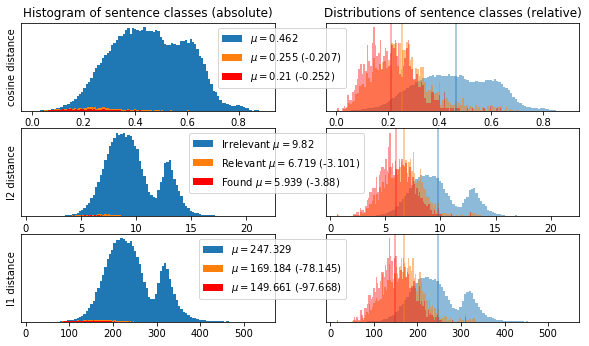

In [708]:
fig = plt.figure()
fig.set_size_inches(10, 5.5)
for k in range(1, len(dist_funcs) + 1):
    fig.add_subplot(len(dist_funcs), 2, (k * 2) - 1)
    res_nel = res_dists[k - 1][np.nonzero(np.asarray(Y) == 0)[0]]
    plt.hist(res_dists[k - 1], bins=100, label=("Irrelevant " if k == 2 else '') + "$\mu = $" + str(round(np.mean(res_nel), 3)))
    res_rel = res_dists[k - 1][np.nonzero(np.asarray(Y) == 1)[0]]
    plt.hist(res_rel, bins=100, label=("Relevant " if k == 2 else '') + "$\mu = $" + str(round(np.mean(res_rel), 3)) + \
             " (" + str(round(np.mean(res_rel) - np.mean(res_nel), 3)) + ")")
    res_rel_found = res_dists[k - 1, :-n_rel_missed][np.nonzero(np.asarray(Y[:-n_rel_missed]) == 1)[0]]
    plt.hist(res_rel_found, bins=100, color='red', label=("Found " if k == 2 else '') + \
             "$\mu = $" + str(round(np.mean(res_rel_found), 3)) + \
             " (" + str(round(np.mean(res_rel_found) - np.mean(res_nel), 3)) + ")")
    if k == 1:
        plt.title("Histogram of sentence classes (absolute)")
    plt.yticks([])
    plt.ylabel(dist_funcs[k - 1][0].__name__)
    plt.legend(loc="upper right", bbox_to_anchor=(1.3 if k != 2 else 1.37, 1.0))
    ax = fig.add_subplot(len(dist_funcs), 2, k * 2)
    _, _, p = plt.hist(res_dists[k - 1], density=True, bins=100, alpha=0.5)
    plt.axvline(x=np.mean(res_nel), color=p[0].get_facecolor())
    res_rel = res_dists[k - 1][np.nonzero(np.asarray(Y) == 1)[0]]
    _, _, p = plt.hist(res_rel, density=True, bins=100, alpha=0.5)
    plt.axvline(x=np.mean(res_rel), color=p[0].get_facecolor())
    _, _, p = plt.hist(res_rel_found, density=True, bins=100, alpha=0.4, color='red')
    plt.axvline(x=np.mean(res_rel_found), color=p[0].get_facecolor())
    if k == 1:
        plt.title("Distributions of sentence classes (relative)")
    plt.yticks([])
    ax.set_zorder(-1)
plt.savefig("graphs/relevance_dists.pdf", format='pdf')
plt.show()

In [ ]:
# avg class gap (cos, l1), run#, desc
-0.33458102400039225, -5.399345344291559   0000  :  no truncation, no OOVs (idfs + Qm) (also 0008)
-0.28619001928751375, -4.326701143373185   0001  :  truncation
-0.28605219995056963, -4.3247937592758525  0002  :  including OOVs + truncation
-0.33456165335580834, -5.3989794715422885  0003  :  including OOVs, no truncation
-0.148858105523899, -2.2402949968138657    0004  :  no query model
-0.21190805914639327, -3.1795841058694583  0005  :  no idf
-0.2862546382052181, -4.1563099773182905   0006  :  no softmax
-0.10288761852999107, -1.004849702060036   0007  :  no idf or query model

In [7]:
claims, claims_vocab = load_claims(n=1000, test_10=False)  # Load training & dev claims
claims_dev, claims_vocab_dev = load_claims(dev=True)
claims += claims_dev
claims_vocab |= claims_vocab_dev
N_claims = len(claims)
load_732 = False
N_claims

1010

In [5]:
claims, claims_vocab = load_claims(n=732, test_10=False)  # Import Lidstone-retrieved claims (optionally, to compare)
N_claims = len(claims)
load_732 = True  # Whether we are comparing with the lidstone results from earlier (before we started filtering for relevance)

In [6]:
all_relsamples, Y, res, res_dists, idx_freqs, arg_min_idx, n_rel_missed = load_ld("rel_dists_025_import")
# _,              Y, res, res_dists, idx_freqs, arg_min_idx               = load_ld("rel_dists_015") # old format import
_,              Y, res, res_dists, idx_freqs, arg_min_idx               = load_ld("rel_dists_005") # old format import

In [5]:
# save_ld((all_relsamples, Y, res, res_dists, idx_freqs, arg_min_idx, n_rel_missed), "rel_dists_0008")  # Load Dirichlet again
all_relsamples, Y, res, res_dists, idx_freqs, arg_min_idx, n_rel_missed = load_ld("rel_dists_0008")
# _,              Y, res, res_dists, idx_freqs, arg_min_idx               = load_ld("rel_dists_0007") # old format import
_,              Y, res, res_dists, idx_freqs, arg_min_idx               = load_ld("rel_dists_0005") # old format import
# _,              Y, res, res_dists, idx_freqs, arg_min_idx               = load_ld("rel_dists_0004") # old format import

In [6]:
len(Y), n_rel_missed, len(Y) - n_rel_missed, max([d[4] for d in all_relsamples])

(70445, 1047, 69398, 1009)

In [8]:
# Filter out invalid sentences (punctuation etc) using a rule that they must contain 3 alphabetical (non-number or punct.) words
rchs = punct + '0123456789'
min_valid_words = 3
new_is_ar = [i for i in range(len(all_relsamples)) if len([w for w in all_relsamples[i][1].split(' ') if w[0] not in rchs]) >= \
             min_valid_words]
frac = len(new_is_ar) / len(all_relsamples)
if frac < 1.0:
    print(frac, sum([res_dists[1][i] < 6.0 for i in range(len(all_relsamples)) if i not in new_is_ar]))
    all_relsamples = [all_relsamples[i] for i in new_is_ar]
    Y = [y for _, _, y, _, _, _, _, _ in all_relsamples]
    res = res[:, new_is_ar]
    res_dists = res_dists[:, new_is_ar]
    idx_freqs = [[ix[i] for i in new_is_ar] for ix in idx_freqs]

0.968869330683512 1


In [9]:
X, Y = res, np.asarray(Y).astype(int)  # Assemble final data shape prior to cross validation relevance modelling
use_components = True
X = np.hstack([res_dists.T] + ([X.swapaxes(0, 1).reshape((X.shape[1], X.shape[0] * X.shape[2]))] if use_components else []))
# X = np.hstack([res_dists[1:2].T] + ([X.swapaxes(0, 1).reshape((X.shape[1], X.shape[0] * X.shape[2]))] if use_components else []))
# X = X.swapaxes(0, 1).reshape((X.shape[1], X.shape[0] * X.shape[2]))
ci = np.asarray([d[4] for d in all_relsamples])           # Claim indices for each sentence
ei = np.asarray([d[7] for d in all_relsamples])           # Evidence ids for each sentence
for i in range(len(claims)): claims[i]["claim_i"] = i
if load_732:
    new_ix = np.asarray([i for i in range(len(X) - n_rel_missed) if ci[i] < 732])
    X, Y, ci, ei = X[new_ix], Y[new_ix], ci[new_ix], ei[new_ix]
    n_rel_missed = 0
if n_rel_missed > 0:  # Store missed relevant samples
    X_mr, Y_mr, ci_mr, ei_mr = X[-n_rel_missed:], Y[-n_rel_missed:], ci[-n_rel_missed:], ei[-n_rel_missed:]
    X_, Y_, ci_, ei_ = X[:-n_rel_missed], Y[:-n_rel_missed], ci[:-n_rel_missed], ei[:-n_rel_missed]
else:
    X_mr, Y_mr, ci_mr, ei_mr = [None] * 4
    X_, Y_, ci_, ei_ = X, Y, ci, ei
X_.shape, Y_.shape, ci_.shape, ei_.shape

((67205, 3075), (67205,), (67205,), (67205, 2))

In [223]:
N_df = len(dist_funcs)
dfr, cur_t = range(N_df), 0  # Evaluate 1D thresholds for task
res_dists_ = res_dists[:, :-n_rel_missed] if n_rel_missed > 0 else res_dists
def macro_f1(_, probs, ci=ci_, ei=ei_, cs=claims, n=5, strict_rel=True, extra_fs=[], verbose=False):
    return eval_rel(probs, ci, ei, cs, n=n, strict_rel=strict_rel, extra_fs=extra_fs, verbose=verbose)#[0]
def macro_recall(*arg, **kwargs): return macro_f1(*args, **kwargs)[1]
def macro_precision(*arg, **kwargs): return macro_f1(*args, **kwargs)[2]
def userdef(Y_, preds):
    global cur_t
    return -abs(cur_t - 5.9032)  # Manually add to the graph the best threshold given by a 1D LR (l1 distance) (see below)
oneD_sfuncs = [accuracy,precision,recall,f1_score,f3_score,f10_score,negative_log_loss,macro_f1,macro_recall,macro_precision]
oneD_scores = [[[] for _ in dfr] for _ in range(len(oneD_sfuncs))]
oneD_thresh_res = []
tcount, count = N_df * len(oneD_sfuncs), 0
for k in dfr:
    min_, max_ = np.min(res_dists_[k]), np.max(res_dists_[k])
    thresh_vals = np.linspace(min_ + 1e-4, max_ - 1e-4, 501)
    for t in thresh_vals:
        cur_t = t
        preds = (res_dists_[k] < t).astype(int).flatten()
        probs = 1.0 - (((res_dists_[k] - t) * 0.5 / max(max(res_dists_[k]) - t, t - min(res_dists_[k]))) + 0.5)
        for j in range(len(oneD_sfuncs) - 2):
            oneD_scores[j][k].append(oneD_sfuncs[j](Y_, preds if oneD_sfuncs[j] is not macro_f1 else probs))
        m_f1, m_r, m_p = oneD_scores[j][k][-1][:3]
        oneD_scores[j][k][-1] = m_f1
        oneD_scores[j + 1][k].append(m_r), oneD_scores[j + 2][k].append(m_p)
    argmaxs = {}
    for j in range(len(oneD_sfuncs)):
        argmax_i = np.argmax(oneD_scores[j][k])
        t = thresh_vals[argmax_i]
        preds = (res_dists_[k] < t).astype(int).flatten()
        probs = 1.0 - (((res_dists_[k] - t) * 0.5 / max(max(res_dists_[k]) - t, t - min(res_dists_[k]))) + 0.5)
        f1m = macro_f1(Y_, probs)[0]
        argmaxs[oneD_sfuncs[j].__name__] = argmax_i, t, oneD_scores[j][k][argmax_i], f1m
        count += 1
        sys_print("\rEvaluations: " + str(count) + '/' + str(tcount) + '     ')
    oneD_thresh_res.append(argmaxs)
tau, tau_dfunc = .42, 0
tau, tau_dfunc = 5.90324953, 1

Evaluations: 30/30     

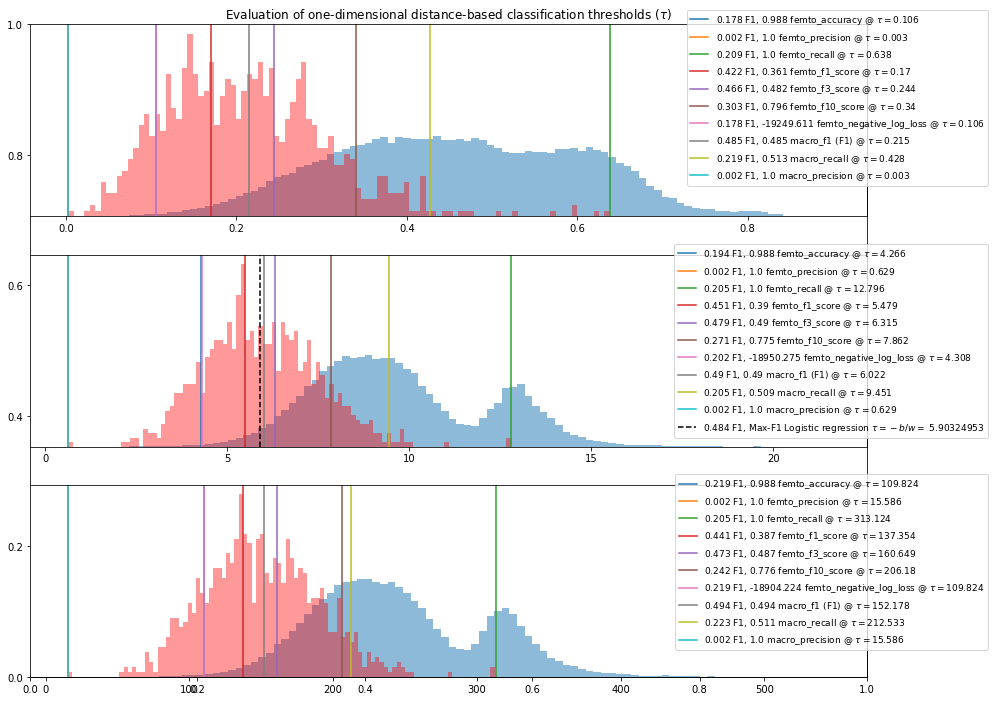

In [224]:
fig = plt.figure()  # Plot evaluation of ideal 1D threshold classifiers
fig.set_size_inches(15, 12)
colours = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.title("Evaluation of one-dimensional distance-based classification thresholds ($\\tau$)")
for k in dfr:
    fig.add_subplot(N_df, 1, k + 1)
    res_nel = res_dists_[k][np.nonzero(Y_ == 0)[0]]
    plt.hist(res_dists_[k], bins=100, density=True, alpha=0.5)
    res_rel_found = res_dists_[k][np.nonzero(Y_ == 1)[0]]
    plt.hist(res_rel_found, bins=100, density=True, alpha=0.4, color="red")
    j = -1
    for j in range(len(oneD_sfuncs)):
        name = oneD_sfuncs[j].__name__
        r = oneD_thresh_res[k][name]
        plt.axvline(x=r[1], label=str(round(r[3], 3)) + ' F1, ' + str(round(r[2], 3)) + \
          (' femto_' if j < 7 else ' ') + name + (' (F1)' if name == "macro_f1" else '') + ' @ $\\tau =$' + str(round(r[1], 3)),
                    color=colours[j])
    if k == tau_dfunc:
        preds = (res_dists_[k] < tau).astype(int).flatten()
        probs = 1.0 - (((res_dists_[k] - tau) * 0.5 / max(max(res_dists_[k]) - tau, tau - min(res_dists_[k]))) + 0.5)
        f1m = macro_f1(Y_, probs)[0]
        plt.axvline(x=tau, ls='--', label=str(round(f1m, 3)) + " F1, Max-F1 Logistic regression $\\tau = -b/w = $ " + str(tau),
                    color="black")
    plt.legend(loc="upper right", bbox_to_anchor=(1.15, 1.1 if k == 0 else 1.08), prop={'size': 9})
    plt.yticks([])
plt.show()

In [10]:
# Define method to generate a new logistic regression model for a given data subset (parameters described further below)
def new_model(X, Y, add_relmissed, X_mr, ci_mr, idx, return_steps=False, verbose=False, init_w=None, ret_train_X=False,
              C=None, eta=None, usampl_ratio=None, proximity=-1, pc_train=1.0, feat_pc=1.0, n_pca=5, print_steps=500):
#     m = Pipeline(steps=[("scale", RobustScaler())] + \
    m = Pipeline(steps=[("scale", StandardScaler())] + \
            ([("pca", PCA(n_components=round(n_pca)))] if n_pca != -1 else []) + \
#             [("select", SelectKBest(f_classif, k=2))] + \
            ([("select", SelectKBest(mutual_info_classif, k=round(min(n_pca, feat_pc))))] if feat_pc != -1 else []) + \
#             ([("select", SelectPercentile(mutual_info_classif, feat_pc*100.0))] if feat_pc < 1.0 else []) + \
            ([("model", LR(eta=eta, C=10.0 ** C, regularisation='l2', w_init='uniform' if init_w is None else init_w,
              return_steps=return_steps, print_steps=print_steps, max_iter=50000, no_imp_stop=100, tol=1e-3, verbose=verbose))]\
                if not ret_train_X else []))
    if add_relmissed:
        X_mr = X_mr[[i for i in range(len(X_mr)) if ci_mr[i] in idx]]
        X, Y = np.vstack([X, X_mr]), np.hstack([Y, np.ones(len(X_mr))])
    if proximity != -1:
        if usampl_ratio == -1: usampl_ratio = 1.0
        nel_idx, rel_idx = np.nonzero(Y == 0)[0], np.nonzero(Y == 1)[0]
        X_ = StandardScaler().fit_transform(X)
#         X_ = PCA(n_components=220).fit_transform(StandardScaler().fit_transform(X))
        nel_dists = [l2_distance(np.tile(X_[nel_idx[i]], (len(rel_idx), 1)), X_[rel_idx]) for i in range(len(nel_idx))]
        nel_dists = np.mean(nel_dists, axis=1)
        dist_ord = np.argsort(nel_dists)
        n_maj = round(len(rel_idx) * usampl_ratio)
        min_prox = n_maj / len(nel_idx)
        proximity = min(1.0, min_prox + (proximity * ((len(nel_idx) - n_maj) / len(nel_idx))))
        dist_ord = dist_ord[:max(n_maj, round(len(nel_idx) * proximity))]
        nel_i = dist_ord[::int(len(dist_ord) // n_maj)][:n_maj]
        train_idx = np.hstack([nel_idx[nel_i], rel_idx])
        X, Y = X[train_idx], Y[train_idx]
    if usampl_ratio != -1 and proximity == -1:
        nel_idx, rel_idx = np.nonzero(Y == 0)[0], np.nonzero(Y == 1)[0]
        n_maj = round(len(rel_idx) * usampl_ratio)
        np.random.shuffle(nel_idx)
        train_idx = np.hstack([nel_idx[:int(n_maj)], rel_idx])
        X, Y = X[train_idx], Y[train_idx]
    if pc_train != 1.0:  # If resizing, stratify the samples (so that our learning curve is smooth & representative)
        nel_idx, rel_idx = np.nonzero(Y == 0)[0], np.nonzero(Y == 1)[0]
        np.random.shuffle(nel_idx), np.random.shuffle(rel_idx)
        shuf_idx, rel_ratio, i = [], len(nel_idx) // len(rel_idx), -1
        for i in range(len(rel_idx)):
            shuf_idx += [nel_idx[i * rel_ratio:(i + 1) * rel_ratio], rel_idx[i:i + 1]]
        shuf_idx.append(nel_idx[(i + 1) * rel_ratio:])
        shuf_idx = np.hstack(shuf_idx)
        X, Y = X[shuf_idx], Y[shuf_idx]
        n_train = int(np.ceil(X.shape[0] * pc_train))
        X, Y = X[:n_train], Y[:n_train]
    if ret_train_X:
        for (name, m_) in m.steps:
            if name != "model": X = m_.fit_transform(X, Y)
        return X, Y
    print(), m.fit(X, Y)
    return m, len(X)
# Define model training and validation set performance optimisation pipeline
def evaluate_params(train_idx, ci, ei, X_mr, ci_mr, cls, cv_k, pc_train,
      add_relmissed, proximity_undersampling, X, Y, sr,
                    C=None, eta=None, proximity=None, usampl_ratio=None, feat_pc=None, n_pca=None):
    trtr_inds, val_inds = gen_cv_inds(cv_k, len(train_idx))
    cv_probs, val_iidxs = [], []
    for cv_i in range(cv_k):
        trtr_idx, val_idx = trtr_inds[cv_i], val_inds[cv_i]
        trtr_idx, val_idx  = [train_idx[i] for i in trtr_idx], [train_idx[i] for i in val_idx]
        trtr_iidx, val_iidx = [i for i in range(len(X)) if ci[i] in trtr_idx], [i for i in range(len(X)) if ci[i] in val_idx]
        val_iidxs += val_iidx
        X_trtr_f, Y_trtr_f, ci_trtr_f = X[trtr_iidx], Y[trtr_iidx], ci[trtr_iidx]
        X_val_f, Y_val_f, ci_val_f = X[val_iidx], Y[val_iidx], ci[val_iidx]
        m, n_tr = new_model(X_trtr_f, Y_trtr_f, add_relmissed, X_mr, ci_mr, trtr_idx,
                    C=C, usampl_ratio=usampl_ratio, proximity=proximity, pc_train=pc_train, feat_pc=feat_pc, n_pca=n_pca)
        cv_probs.append(m.predict_proba(X_val_f)[:, 1])
    cv_probs = np.hstack(cv_probs)
    scores = eval_rel(cv_probs, ci[val_iidxs], ei[val_iidxs], cls, strict_rel=sr, verbose=False)
    return tuple(list(scores) + [None if X.shape[1] > 1 else \
                                 m.steps[0][1].inverse_transform([-m.steps[-1][1].intercept_ / m.steps[-1][1].coef_])[0,0,0]])
# Define main function to evaluate and/or optimise relevance classification
def relevance_evaluation(
      optimise_C=True,            # Whether to include individual hyperparameters in the optimisation
      optimise_eta=False,
      optimise_feat_pc=True,
      optimise_n_pca=True,
      balance_classes=True,       # In order of dependence; proximity undersampling requires class balancing to be enabled
      optimise_ratio=True,
      proximity_undersampling=False,  # Select majority class samples closer to minority class
      optimise_proximity=False,
      C=0.32191516454484104,      # Exponent of C (inverse regularisation strength)
      eta=4e-6,                   # Learning rate
      feat_pc=2,                  # Number of features to select
      n_pca=4,                    # Number of PCA output dimensions
      usampl_ratio = 7.5,         # Ratio of majority class to minority class in binary class balancing
      proximity=0.05,             # Proximity of selected majority class samples to minority class (0 = closest, 1 = all data)
      n_pca_range=np.linspace(1.501, 7.499, 5),      # Ranges of hyperparameters
      usampl_ratio_range=np.linspace(7, 9, 5),
      C_range=np.linspace(0, 2, 9),
      eta_range=np.asarray([-4, 0]),
      proximity_range=np.linspace(0, 1, 11),
      feat_pc_range=np.linspace(0.501, 4.499, 11),
      n_reps=5,                   # Number of times to run the outer cross validation
      cv_k=5,                     # Number of outer folds to test optimised model
      cv_k_internal=5,            # Number of internal folds to optimise hyperparameters for validation accuracy
      n_guess=64,                 # Number of uniformly random guesses at hyperparameters
      pc_train=0.5,               # Train with only a subset of the training data (for generating learning curve)
      add_relmissed=False,        # Whether to add the relevance samples missed by the retrieval to the training subset
      strict_rel=True,            # Whether to exclude negatively-classified sentences when less than 5 positive are found
      scoring_fn=0,               # Which score to maximise (0 = macro (Fever) F1)
      n_jobs=n_cpu,               # Multiprocessing number of parllel hyperparameter set evaluations
      return_ntrs=False,          # Also return numbers of datapoints used to train outer cross validation models
      pause=True,                 # Whether to pause after each outer cross validation fold
        ):
    use_ = {"C": True, "eta": True, "feat_pc": feat_pc != None,"n_pca": n_pca != None, "proximity": proximity_undersampling, \
            "usampl_ratio": balance_classes}
    hypopts = {"C": optimise_C, "eta": optimise_eta, "proximity": proximity_undersampling and optimise_proximity,
               "usampl_ratio": balance_classes and optimise_ratio, "feat_pc": optimise_feat_pc, "n_pca": optimise_n_pca}
    hypopts_rs = {"C": C_range, "eta": eta_range, "proximity": proximity_range, "usampl_ratio": usampl_ratio_range,
                 "feat_pc": feat_pc_range, "n_pca": n_pca_range}
    n_hyperparams = sum(hypopts.values())
    r_hyp = range(n_hyperparams)
    hyp_ps = [key for key in hypopts if hypopts[key]]
    stop, scores, top_pars, all_pars, all_probs, n_trs = False, [], [], [], [], []
    for run_i in range(n_reps):
        train_inds, test_inds = gen_cv_inds(cv_k, len(claims))  # Create testing cross validation indices to split claims set
        cv_probs, test_iidxs, top_par, all_par = [], [], [], []
        for cv_i in range(cv_k):
            gc.collect()
            sys_print("Run " + str(run_i + 1) + " Fold " + str(cv_i + 1) + '/' + str(cv_k) + '     ')
            train_idx, test_idx = train_inds[cv_i], test_inds[cv_i]
            train_iidx, test_iidx = [i for i in range(len(X_)) if ci_[i] in train_idx], \
                                    [i for i in range(len(X_)) if ci_[i] in test_idx]
            test_iidxs += test_iidx
            trtr_idx, trtr_iidx = train_idx, train_iidx
            X_train_f, Y_train_f, ci_train_f = X_[train_iidx], Y_[train_iidx], ci_[train_iidx]
            X_test_f, Y_test_f, ci_test_f = X_[test_iidx], Y_[test_iidx], ci_[test_iidx]
            ps = {"C": C, "eta": eta, "proximity": proximity, "usampl_ratio": usampl_ratio, "feat_pc": feat_pc, "n_pca": n_pca}
            for key in ps:
                if not use_[key]: ps[key] = -1
            if n_hyperparams > 0:
                args = train_idx, ci_, ei_, X_mr, ci_mr, claims, cv_k_internal, pc_train, \
                    add_relmissed, proximity_undersampling, X_, Y_, strict_rel
    #             pars=[dict([(hyp_ps[i],r[i]) for i in r_hyp]) for r in itertools.product(*[hypopts_rs[key] for key in hyp_ps])]
                pars = [dict([(hyp_ps[i], np.random.uniform(min(hypopts_rs[hyp_ps[i]]), \
                                                         max(hypopts_rs[hyp_ps[i]]))) for i in r_hyp]) for _ in range(n_guess)]
                opt_res = joblib.Parallel(n_jobs=n_jobs, verbose=2)(delayed(evaluate_params)(*args, **{**ps, **p}) for p in pars)
                opt_r = [r[0] for r in opt_res]
                max_i = np.argmax(opt_r)
                top_ps, opt_max = pars[max_i], opt_res[max_i]
                sys_print(str((opt_max[0], opt_max[1], opt_max[2], opt_max[-1], top_ps)) + '\n')
                ps = {**ps, **top_ps}
                top_par.append((opt_max, deepcopy(ps)))
                all_par.append(list(zip(pars, deepcopy(opt_res))))
                n_trtr = int(np.floor(len(train_idx) * (1.0 - (1.0 / cv_k_internal))))
                trtr_idx = [train_idx[i] for i in np.random.choice(range(len(train_idx)), n_trtr, replace=False)]
                trtr_iidx = [i for i in range(len(X_)) if ci_[i] in trtr_idx]
            X_trtr_f, Y_trtr_f, ci_trtr_f = X_[trtr_iidx], Y_[trtr_iidx], ci_[trtr_iidx]
            m, n_tr = new_model(X_trtr_f, Y_trtr_f, add_relmissed, X_mr, ci_mr, trtr_idx, pc_train=pc_train, **ps)
            n_trs.append(n_tr)
            probs_test = m.predict_proba(X_test_f)[:, 1]
            cv_probs.append(probs_test)
            if pause:
                uimp = input("Press Enter to continue, 's' to stop, 'f' to automate: ")
                if uimp == "s":
                    stop = True
                    break
                if uimp == 'f': pause = False
        top_pars.append(top_par)
        all_pars.append(all_par)
        if stop: break
        cv_probs = np.hstack(cv_probs)
        scores.append(eval_rel(cv_probs, ci_[test_iidxs], ei_[test_iidxs], claims, strict_rel=strict_rel, verbose=False))
        print('\n', scores[-1])
        all_probs.append(cv_probs[np.argsort(test_iidxs)])
    print(np.mean([s[0] for s in scores]))
    pr(top_pars)
    if return_ntrs: return scores, top_pars, all_pars, all_probs, n_trs
    return scores, top_pars, all_pars, all_probs

In [235]:
scores, top_pars, all_pars = relevance_evaluation()  # Get best n-D (3075-D) LR hyperparameters (x4) for validation accuracy

Run 1 Fold 1/5     

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:  2.5min
[Parallel(n_jobs=8)]: Done  64 out of  64 | elapsed:  5.1min finished


(0.5107169213344093, 0.4084158415841584, 0.6813943894389438, None, {'C': 0.46373015009998997, 'usampl_ratio': 7.126172840844593, 'feat_pc': 3.8826237085486643, 'n_pca': 5.435100709842681})
Press Enter to continue, 's' to stop, 'f' to automate: f
Run 1 Fold 2/5     

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:  2.6min
[Parallel(n_jobs=8)]: Done  64 out of  64 | elapsed:  5.3min finished


(0.5097891524157498, 0.4034653465346535, 0.6922029702970296, None, {'C': 1.3978851114598585, 'usampl_ratio': 7.6128914218780555, 'feat_pc': 1.9990911170105532, 'n_pca': 6.344356368241323})
Run 1 Fold 3/5     

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:  2.5min
[Parallel(n_jobs=8)]: Done  64 out of  64 | elapsed:  5.4min finished


(0.5123402948380247, 0.4034653465346535, 0.7016914191419142, None, {'C': 0.519290047317994, 'usampl_ratio': 7.690376172519182, 'feat_pc': 2.36467135926082, 'n_pca': 2.7491152792587346})
Run 1 Fold 4/5     

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:  2.5min
[Parallel(n_jobs=8)]: Done  64 out of  64 | elapsed:  5.3min finished


(0.5159011974495878, 0.40717821782178215, 0.7038366336633664, None, {'C': 1.7750672074696596, 'usampl_ratio': 8.312498922444771, 'feat_pc': 2.906094143845453, 'n_pca': 4.13884243023679})
Run 1 Fold 5/5     

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:  2.6min
[Parallel(n_jobs=8)]: Done  64 out of  64 | elapsed:  5.3min finished


(0.4955797928467828, 0.40470297029702973, 0.639088283828383, None, {'C': 1.5844343896294792, 'usampl_ratio': 7.133985094621078, 'feat_pc': 3.9728152203298253, 'n_pca': 4.5558165841617})
Run 2 Fold 1/5     

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:  2.5min
[Parallel(n_jobs=8)]: Done  64 out of  64 | elapsed:  5.2min finished


(0.5109182432116142, 0.40594059405940597, 0.6891295379537953, None, {'C': 0.04959462854557106, 'usampl_ratio': 8.595563473496275, 'feat_pc': 2.951057466190423, 'n_pca': 5.250055002388515})
Run 2 Fold 2/5     

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:  2.5min
[Parallel(n_jobs=8)]: Done  64 out of  64 | elapsed:  5.3min finished


(0.5119190911827353, 0.4121287128712871, 0.6754744224422442, None, {'C': 0.0570019858086499, 'usampl_ratio': 7.265296937832504, 'feat_pc': 2.601987385561038, 'n_pca': 5.2527925013457715})
Run 2 Fold 3/5     

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:  2.4min
[Parallel(n_jobs=8)]: Done  64 out of  64 | elapsed:  5.2min finished


(0.5088046514627466, 0.4084158415841584, 0.6746287128712871, None, {'C': 0.25337728005489346, 'usampl_ratio': 7.0277680520838715, 'feat_pc': 1.641063635752447, 'n_pca': 3.9348526712810035})
Run 2 Fold 4/5     

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:  2.6min
[Parallel(n_jobs=8)]: Done  64 out of  64 | elapsed:  5.3min finished


(0.5073221128289653, 0.40717821782178215, 0.672792904290429, None, {'C': 1.2130204899088108, 'usampl_ratio': 7.204416571922567, 'feat_pc': 4.326500358871965, 'n_pca': 4.127420899589613})
Run 2 Fold 5/5     

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:  2.5min
[Parallel(n_jobs=8)]: Done  64 out of  64 | elapsed:  5.3min finished


(0.49665453697404, 0.3972772277227723, 0.6623349834983497, None, {'C': 0.659467784961099, 'usampl_ratio': 7.1429450444796245, 'feat_pc': 3.759022027907739, 'n_pca': 3.6547904900441135})
Run 3 Fold 1/5     

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:  2.6min
[Parallel(n_jobs=8)]: Done  64 out of  64 | elapsed:  5.2min finished


(0.5072292361197542, 0.4121287128712871, 0.6593853135313531, None, {'C': 1.600832748365166, 'usampl_ratio': 7.331293310492744, 'feat_pc': 1.8637291850842232, 'n_pca': 7.40560402307025})
Run 3 Fold 2/5     

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:  2.6min
[Parallel(n_jobs=8)]: Done  64 out of  64 | elapsed:  5.3min finished


(0.5134924495867146, 0.40594059405940597, 0.6985767326732674, None, {'C': 1.0815035048350912, 'usampl_ratio': 7.865398985050268, 'feat_pc': 3.4029789253634832, 'n_pca': 7.2902651789897295})
Run 3 Fold 3/5     

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:  2.5min
[Parallel(n_jobs=8)]: Done  64 out of  64 | elapsed:  5.3min finished


(0.5060793434241162, 0.4034653465346535, 0.6786922442244224, None, {'C': 0.885159607817465, 'usampl_ratio': 7.845878872939815, 'feat_pc': 1.8947734410399697, 'n_pca': 4.253485441699182})
Run 3 Fold 4/5     

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:  2.5min
[Parallel(n_jobs=8)]: Done  64 out of  64 | elapsed:  5.2min finished


(0.5024808635145989, 0.39232673267326734, 0.6986386138613861, None, {'C': 1.369394232542635, 'usampl_ratio': 8.037547033764918, 'feat_pc': 3.3325009597277173, 'n_pca': 5.6730990103710734})
Run 3 Fold 5/5     

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:  2.5min
[Parallel(n_jobs=8)]: Done  64 out of  64 | elapsed:  5.3min finished


(0.5104220898949305, 0.40965346534653463, 0.6769389438943895, None, {'C': 1.7642744282055098, 'usampl_ratio': 7.645027685075502, 'feat_pc': 2.9461651751461777, 'n_pca': 7.164014870541623})
Run 4 Fold 1/5     

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:  2.6min
[Parallel(n_jobs=8)]: Done  64 out of  64 | elapsed:  5.2min finished


(0.5053803920064397, 0.3948019801980198, 0.7020008250825083, None, {'C': 1.7393140432697143, 'usampl_ratio': 7.425207916989703, 'feat_pc': 2.8079677358323543, 'n_pca': 1.6147309088222168})
Run 4 Fold 2/5     

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:  2.6min
[Parallel(n_jobs=8)]: Done  64 out of  64 | elapsed:  5.4min finished


(0.5146492178721759, 0.40717821782178215, 0.6991955445544553, None, {'C': 1.7987504719131013, 'usampl_ratio': 8.409229367425429, 'feat_pc': 1.8688350904010789, 'n_pca': 7.12341548660072})
Run 4 Fold 3/5     

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:  2.5min
[Parallel(n_jobs=8)]: Done  64 out of  64 | elapsed:  5.2min finished


(0.5049915960720303, 0.4034653465346535, 0.6747937293729374, None, {'C': 0.6143655968838133, 'usampl_ratio': 7.415711981753736, 'feat_pc': 3.240189900631631, 'n_pca': 2.9326192694688507})
Run 4 Fold 4/5     

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:  2.5min
[Parallel(n_jobs=8)]: Done  64 out of  64 | elapsed:  5.2min finished


(0.5078808469205819, 0.4084158415841584, 0.6713902640264027, None, {'C': 0.8918512091928466, 'usampl_ratio': 7.34671314078244, 'feat_pc': 3.768540436763859, 'n_pca': 6.099791064032676})
Run 4 Fold 5/5     

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:  2.5min
[Parallel(n_jobs=8)]: Done  64 out of  64 | elapsed:  5.3min finished


(0.5055096815517595, 0.400990099009901, 0.6837252475247524, None, {'C': 1.8271693631574624, 'usampl_ratio': 8.104439741434122, 'feat_pc': 1.8486403530067692, 'n_pca': 7.103322971210426})
Run 5 Fold 1/5     

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:  2.8min
[Parallel(n_jobs=8)]: Done  64 out of  64 | elapsed:  5.6min finished


(0.5099269177743232, 0.4084158415841584, 0.6785891089108911, None, {'C': 1.850175798777148, 'usampl_ratio': 7.3415237345052, 'feat_pc': 3.5179891007632484, 'n_pca': 3.4133447332937803})
Run 5 Fold 2/5     

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:  2.6min
[Parallel(n_jobs=8)]: Done  64 out of  64 | elapsed:  5.6min finished


(0.5036703722401377, 0.3948019801980198, 0.6954414191419142, None, {'C': 0.9802571676186558, 'usampl_ratio': 8.283439520543833, 'feat_pc': 2.396430262769319, 'n_pca': 2.979429910675999})
Run 5 Fold 3/5     

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:  2.8min
[Parallel(n_jobs=8)]: Done  64 out of  64 | elapsed:  5.9min finished


(0.5050817707011641, 0.40222772277227725, 0.6786097359735973, None, {'C': 1.8161243163148455, 'usampl_ratio': 7.633622361248955, 'feat_pc': 4.098690221122277, 'n_pca': 2.6154522628399794})
Run 5 Fold 4/5     

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:  2.7min
[Parallel(n_jobs=8)]: Done  64 out of  64 | elapsed:  5.6min finished


(0.5037169212590171, 0.40470297029702973, 0.6668729372937293, None, {'C': 1.8643003997521705, 'usampl_ratio': 7.401414706509036, 'feat_pc': 2.3410866582852194, 'n_pca': 4.410205102565534})
Run 5 Fold 5/5     

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:  2.6min
[Parallel(n_jobs=8)]: Done  64 out of  64 | elapsed:  5.4min finished


(0.5114913394375232, 0.4084158415841584, 0.6841584158415841, None, {'C': 0.7506888526799738, 'usampl_ratio': 7.771899258632265, 'feat_pc': 3.606242340246174, 'n_pca': 6.052783962836319})
0.5014398499003668
[   [   (   (   0.5107169213344093,
                0.4084158415841584,
                0.6813943894389438,
                0.32214570861987274,
                0.3935121465443248,
                0.27269109297411176,
                0.20411331655950052,
                0.2772512088301562,
                0.16150805940214424,
                0.20787867579064173,
                0.2580348943985308,
                0.1740476927841437,
                None),
            {   'C': 0.46373015009998997,
                'eta': -1,
                'feat_pc': 3.8826237085486643,
                'n_pca': 5.435100709842681,
                'proximity': -1,
                'usampl_ratio': 7.126172840844593}),
        (   (   0.5097891524157498,
                0.4034653465346535,
                

                0.21417780132242434,
                0.2748860517237038,
                0.1754335213666972,
                0.21233140655105973,
                0.24741805118994162,
                0.18596017549780627,
                None),
            {   'C': 1.0815035048350912,
                'eta': -1,
                'feat_pc': 3.4029789253634832,
                'n_pca': 7.2902651789897295,
                'proximity': -1,
                'usampl_ratio': 7.865398985050268}),
        (   (   0.5060793434241162,
                0.4034653465346535,
                0.6786922442244224,
                0.32166784022612244,
                0.38934547987765816,
                0.27403410081981505,
                0.19619010175330207,
                0.2570888839822379,
                0.15861714043532224,
                0.1973853802246364,
                0.23457330415754923,
                0.17037507946598857,
                None),
            {   'C': 0.885159607817465,
         

In [286]:
# save_ld((top_pars, np.mean([s[0] for s in scores])), "best_hyperparams_5fcv_topPars_testAcc_overfittingQuantification")
top_pars, test_acc = load_ld("best_hyperparams_5fcv_topPars_testAcc_overfittingQuantification")
val_acc = np.mean(sum([[a_[0][0] for a_ in b] for b in top_pars], []))
val_acc, test_acc, "Our internal cross validation best hyperparameters overfit by", val_acc - test_acc

(0.5074450590247827,
 0.5014398499003668,
 'Our internal cross validation best hyperparameters overfit by',
 0.006005209124415822)

In [ ]:
# (Final hyperparameters, used in the next section, were chosen reasonably from the modal points in the above optimisation)

In [263]:
scores, top_pars, all_pars, all_probs = relevance_evaluation(optimise_C=False,  # Test best 1-D LR (uses only l1 distance as x)
      optimise_eta=False, optimise_feat_pc=False, optimise_n_pca=False, optimise_ratio=False, optimise_proximity=False,
      feat_pc=None, n_pca=None, C=0.32191516454484104, usampl_ratio=7.5, n_reps=10, cv_k=10)

Run 1 Fold 1/10     Press Enter to continue, 's' to stop, 'f' to automate: f
Run 1 Fold 2/10     Run 1 Fold 3/10     Run 1 Fold 4/10     Run 1 Fold 5/10     Run 1 Fold 6/10     Run 1 Fold 7/10     Run 1 Fold 8/10     Run 1 Fold 9/10     Run 1 Fold 10/10     
 (0.48528201971570784, 0.3792079207920792, 0.6737458745874587, 0.3108773299529602, 0.36628121053863627, 0.2700321333168048, 0.21015323776569453, 0.26066217044757817, 0.17604140786749486, 0.21270405689348632, 0.24040920716112532, 0.1907246376811594)
Run 2 Fold 1/10     Run 2 Fold 2/10     Run 2 Fold 3/10     Run 2 Fold 4/10     Run 2 Fold 5/10     Run 2 Fold 6/10     Run 2 Fold 7/10     Run 2 Fold 8/10     Run 2 Fold 9/10     Run 2 Fold 10/10     
 (0.48434585836272115, 0.3801980198019802, 0.6670792079207921, 0.3094910642599106, 0.36786536895447786, 0.26710569564631387, 0.20917264865129728, 0.26173513182096875, 0.17419104745582897, 0.21160628406540563, 0.2411399342345634, 0.18851756640959727)
Run 3 Fold 1/10     Run 3 Fold 2/10     

In [344]:
# save_ld((scores, top_pars, all_pars, all_probs), "best_1feat_10fcv")
scores, top_pars, all_pars, all_probs = load_ld("best_1feat_10fcv")

In [331]:
scores, top_pars, all_pars, all_probs = relevance_evaluation(optimise_C=False,  # Test best n-D LR (3075-D; all features)
      optimise_eta=False, optimise_feat_pc=False, optimise_n_pca=False, optimise_ratio=False, optimise_proximity=False,
      C=1.127, feat_pc=2, n_pca=4, usampl_ratio=7.5, n_reps=10, cv_k=10)

Run 1 Fold 1/10     
Press Enter to continue, 's' to stop, 'f' to automate: f
Run 1 Fold 2/10     
Run 1 Fold 3/10     
Run 1 Fold 4/10     
Run 1 Fold 5/10     
Run 1 Fold 6/10     
Run 1 Fold 7/10     
Run 1 Fold 8/10     
Run 1 Fold 9/10     
Run 1 Fold 10/10     

 (0.50045596805074, 0.39702970297029705, 0.6767491749174918, 0.3184371931617953, 0.3863809705146339, 0.27081525344884116, 0.21349580208934182, 0.2723216840384222, 0.17556987377131264, 0.2141395055896709, 0.2484472049689441, 0.18815716657443277)
Run 2 Fold 1/10     
Run 2 Fold 2/10     
Run 2 Fold 3/10     
Run 2 Fold 4/10     
Run 2 Fold 5/10     
Run 2 Fold 6/10     
Run 2 Fold 7/10     
Run 2 Fold 8/10     
Run 2 Fold 9/10     
Run 2 Fold 10/10     

 (0.5040195098173528, 0.400990099009901, 0.6783003300330033, 0.319097923498251, 0.3859189243100134, 0.2720014749149432, 0.21818196610610757, 0.2740384222358471, 0.18124028493032185, 0.21821086261980832, 0.2495432955791012, 0.19386886176554075)
Run 3 Fold 1/10     
Run 3 Fol

In [631]:
# save_ld((scores, top_pars, all_pars, all_probs), "best_multifeat_10fcv")
scores, top_pars, all_pars, all_probs = load_ld("best_multifeat_10fcv")

In [624]:
scores, top_pars, all_pars, all_probs = relevance_evaluation(optimise_C=False,  # Test best n-D LR (3075-D; all features)
      optimise_eta=False, optimise_feat_pc=False, optimise_n_pca=False, optimise_ratio=False, optimise_proximity=False,
      C=1.127, feat_pc=2, n_pca=4, usampl_ratio=7.5, n_reps=10, cv_k=10, pc_train=0.5)

Run 1 Fold 1/10     
Press Enter to continue, 's' to stop, 'f' to automate: f
Run 1 Fold 2/10     
Run 1 Fold 3/10     
Run 1 Fold 4/10     
Run 1 Fold 5/10     
Run 1 Fold 6/10     
Run 1 Fold 7/10     
Run 1 Fold 8/10     
Run 1 Fold 9/10     
Run 1 Fold 10/10     

 (0.5024309693088358, 0.4069306930693069, 0.6565016501650166, 0.3134132555982949, 0.3940938956533016, 0.26015348667309446, 0.20744814629638045, 0.2798324136521561, 0.16481534980018298, 0.2085761243089795, 0.25502374862988675, 0.17644084934277046)
Run 2 Fold 1/10     
Run 2 Fold 2/10     
Run 2 Fold 3/10     
Run 2 Fold 4/10     
Run 2 Fold 5/10     
Run 2 Fold 6/10     
Run 2 Fold 7/10     
Run 2 Fold 8/10     
Run 2 Fold 9/10     
Run 2 Fold 10/10     

 (0.5022298078275347, 0.403960396039604, 0.6636798679867986, 0.3156854172796779, 0.3921062930468871, 0.26419436689616804, 0.21243922936154508, 0.27639893725730635, 0.17251795440919473, 0.2132921174652241, 0.25210084033613445, 0.18483793195821055)
Run 3 Fold 1/10     
Run 

In [630]:
# save_ld((scores, top_pars, all_pars, all_probs), "best_multifeat_10fcv_half")
scores, top_pars, all_pars, all_probs = load_ld("best_multifeat_10fcv_half")

In [335]:
0.5038385269485952, 0.48499161975262267, "Multiple features increase F1 score by", 0.5038385269485952 - 0.48499161975262267

(0.5038385269485952,
 0.48499161975262267,
 'Multiple features increase F1 score by',
 0.01884690719597254)

In [582]:
# Compute the n-D (best) LR performance metrics over the 10 development set claims (the first 10 verifiable) for question 4/5
scores_10dev = [eval_rel(pr, ci_, ei_, claims[-10:], print_preds=True) for pr in all_probs] # Analyse the evidence predictions
'macro f1, recall, precision:', [np.mean([s[i] for s in scores_10dev]) for i in range(3)]

(   'Fox 2000 Pictures released the film Soul Food.',
    [('Soul_Food_-LRB-film-RRB-', 0, True)])
(   'Telemundo is a English-language television network.',
    [('List_of_Telemundo_affiliates_-LRB-table-RRB-', 0, False)])
("Damon Albarn's debut album was released in 2011.", [('Gorillaz', 12, False)])
('There is a capital called Mogadishu.', [])
('Savages was exclusively a German film.', [])
('Andrew Kevin Walker is only Chinese.', [])
(   'The Cretaceous ended.',
    [('Mesozoic', 10, False), ('Ischioceratops', 2, False)])
("Murda Beatz's real name is Marshall Mathers.", [])
('Nicholas Brody is a character on Homeland.', [('Nicholas_Brody', 1, True)])
('Charles Manson has been proven innocent of all crimes.', [])
(   'Fox 2000 Pictures released the film Soul Food.',
    [('Soul_Food_-LRB-film-RRB-', 0, True)])
(   'Telemundo is a English-language television network.',
    [('List_of_Telemundo_affiliates_-LRB-table-RRB-', 0, False)])
(   "Damon Albarn's debut album was released in 201

('macro f1, recall, precision:', [0.31111111111111106, 0.2, 0.7])

In [611]:
# Plot the learning curve
rez = []
for pc in [0.04, 0.08, 0.16, 0.24, 0.32, 0.4, 0.5, 0.65, 0.8]:
    rez.append(relevance_evaluation(optimise_C=False,  # Test best n-D LR (3075-D; all features)
      optimise_eta=False, optimise_feat_pc=False, optimise_n_pca=False, optimise_ratio=False, optimise_proximity=False,
      C=1.127, feat_pc=2, n_pca=4, usampl_ratio=7.5, n_reps=10, cv_k=10, pc_train=pc, return_ntrs=True, pause=False))

Run 1 Fold 1/10     
Run 1 Fold 2/10     
Run 1 Fold 3/10     
Run 1 Fold 4/10     
Run 1 Fold 5/10     
Run 1 Fold 6/10     
Run 1 Fold 7/10     
Run 1 Fold 8/10     
Run 1 Fold 9/10     
Run 1 Fold 10/10     

 (0.49238275269398835, 0.3821782178217822, 0.6918976897689768, 0.3175394285963047, 0.37035786820440286, 0.2779059783703172, 0.2108300760727945, 0.2562987941957899, 0.17906332548011705, 0.21014492753623187, 0.23310193642674462, 0.19130434782608696)
Run 2 Fold 1/10     
Run 2 Fold 2/10     
Run 2 Fold 3/10     
Run 2 Fold 4/10     
Run 2 Fold 5/10     
Run 2 Fold 6/10     
Run 2 Fold 7/10     
Run 2 Fold 8/10     
Run 2 Fold 9/10     
Run 2 Fold 10/10     

 (0.4991128969980518, 0.39504950495049507, 0.6776072607260727, 0.3173893010644446, 0.38306688910649306, 0.2709366652643963, 0.2115871407664721, 0.26888820764357246, 0.17441801887792982, 0.21330383946911044, 0.24662038728534894, 0.1879175946547884)
Run 3 Fold 1/10     
Run 3 Fold 2/10     
Run 3 Fold 3/10     
Run 3 Fold 4/10  

Run 6 Fold 2/10     
Run 6 Fold 3/10     
Run 6 Fold 4/10     
Run 6 Fold 5/10     
Run 6 Fold 6/10     
Run 6 Fold 7/10     
Run 6 Fold 8/10     
Run 6 Fold 9/10     
Run 6 Fold 10/10     

 (0.5021686241111551, 0.401980198019802, 0.6688778877887788, 0.3158857213497631, 0.3892275051680992, 0.26580106843798523, 0.2124555468817764, 0.2753259758839158, 0.17296023828781987, 0.21222463543282657, 0.24990865911582025, 0.18441628471286062)
Run 7 Fold 1/10     
Run 7 Fold 2/10     
Run 7 Fold 3/10     
Run 7 Fold 4/10     
Run 7 Fold 5/10     
Run 7 Fold 6/10     
Run 7 Fold 7/10     
Run 7 Fold 8/10     
Run 7 Fold 9/10     
Run 7 Fold 10/10     

 (0.503777832568776, 0.402970297029703, 0.6718481848184817, 0.3174959918877193, 0.3875965920767901, 0.26886851510821286, 0.21171866905758122, 0.27146331493970977, 0.17352799007119998, 0.21184581635850827, 0.24698575082206795, 0.18545953360768175)
Run 8 Fold 1/10     
Run 8 Fold 2/10     
Run 8 Fold 3/10     
Run 8 Fold 4/10     
Run 8 Fold 5/10     

Run 1 Fold 2/10     
Run 1 Fold 3/10     
Run 1 Fold 4/10     
Run 1 Fold 5/10     
Run 1 Fold 6/10     
Run 1 Fold 7/10     
Run 1 Fold 8/10     
Run 1 Fold 9/10     
Run 1 Fold 10/10     

 (0.5012169233618369, 0.401980198019802, 0.6655115511551156, 0.31243985502358707, 0.3879203744550279, 0.2615484500664741, 0.21200971177944863, 0.2766135295319845, 0.17186920634920638, 0.2127331586249422, 0.25210084033613445, 0.184)
Run 2 Fold 1/10     
Run 2 Fold 2/10     
Run 2 Fold 3/10     
Run 2 Fold 4/10     
Run 2 Fold 5/10     
Run 2 Fold 6/10     
Run 2 Fold 7/10     
Run 2 Fold 8/10     
Run 2 Fold 9/10     
Run 2 Fold 10/10     

 (0.5026097383691086, 0.400990099009901, 0.6732178217821783, 0.3143504524437751, 0.38686892315605187, 0.2647273796664041, 0.2094749209503308, 0.27146331493970977, 0.17053370822580854, 0.21005274588892334, 0.24735111435878698, 0.18252898355351846)
Run 3 Fold 1/10     
Run 3 Fold 2/10     
Run 3 Fold 3/10     
Run 3 Fold 4/10     
Run 3 Fold 5/10     
Run 3 Fold 6/

In [612]:
# save_ld(rez, "learning_curve_results")
rez = load_ld("learning_curve_results")

In [650]:
xyz = np.asarray([list(a) for a in zip([r[-1][0] / 7.5 for r in rez], [np.mean([r_[0] for r_ in r[0]]) for r in rez],
                                        [np.std([r_[0] for r_ in r[0]]) for r in rez])])
xyz

array([[3.66666667e+01, 4.96308894e-01, 4.68308998e-03],
       [7.33333333e+01, 4.98609802e-01, 1.70523758e-03],
       [1.45466667e+02, 5.01193337e-01, 1.87086358e-03],
       [2.16800000e+02, 5.00843378e-01, 4.10286159e-03],
       [2.89066667e+02, 5.00535111e-01, 1.93623219e-03],
       [3.64000000e+02, 5.02102173e-01, 2.78637775e-03],
       [4.59600000e+02, 5.03253064e-01, 1.90125463e-03],
       [5.81333333e+02, 5.02867743e-01, 1.32019031e-03],
       [7.32666667e+02, 5.02065379e-01, 2.94215992e-03]])

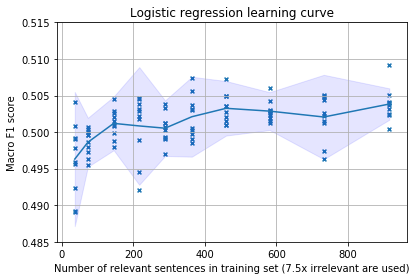

In [677]:
x = xyz[:, 0]
y = xyz[:, 1]
ci = 1.96 * xyz[:, 2]
x = np.hstack([x, [((1/0.8) * x[-1])]])
scores__, _, _, _ = load_ld("best_multifeat_10fcv")  # append scores for full dataset
y = np.hstack([y, [np.mean([s[0] for s in scores__])]])
ci = np.hstack([ci, [np.std([s[0] for s in scores__])]])
fig = plt.figure()
fig.set_size_inches(6, 4)
plt.plot(x, y)
plt.scatter(np.repeat(x, 10),# + (np.random.random(size=len(x) * 10) * 20),
            np.hstack([[r_[0] for r_ in r[0]] for r in rez] + [s[0] for s in scores__]), marker='x', s=15)
plt.fill_between(x, (y - ci), (y + ci), color='b', alpha=.1)
plt.grid(which='both')
plt.ylim(0.485, 0.515)
plt.ylabel("Macro F1 score")
plt.xlabel("Number of relevant sentences in training set (7.5x irrelevant are used)")
plt.title("Logistic regression learning curve")
plt.savefig("graphs/learning_curve.pdf", format='pdf')
plt.tight_layout()
plt.show()

In [478]:
# Analyse the effect of changing the learning rate on model training loss
trX, trY = new_model(X_, Y_, False, X_mr, ci_mr,list(range(len(claims))),ret_train_X=True, feat_pc=2, n_pca=4, usampl_ratio=7.5)
init_w = init_weights('uniform', 1e-2, 3, a=-2.0, b=-2.0) # Keep the initial weights constant (share origin of learning curve)

In [546]:
m = LR(w_init=init_w, eta=1e-5, C=1.127, return_steps=True, print_steps=1, no_imp_stop=50)
m.fit(trX, trY)
us_steps = m.steps
len(us_steps)

|  iteration  |   loss   |  accuracy   |   precision   |   recall   |   f1_score   |   f2_score   |
|  0  |  4930.744275794814  |  0.5840486  |  0.2167043  |  0.969697  |  0.3542435  |  0.5721097  |
|  1  |  5391.794864611623  |  0.5649016  |  0.2118888  |  0.9921437  |  0.3492001  |  0.5713547  |
|  2  |  6548.2784844454945  |  0.4950482  |  0.0016989  |  0.0056117  |  0.0026082  |  0.003842  |
|  3  |  10638.428429746642  |  0.563185  |  0.2110925  |  0.9910213  |  0.3480489  |  0.569898  |
|  4  |  4572.285616294254  |  0.6119107  |  0.2305263  |  0.983165  |  0.3734811  |  0.5947854  |
|  5  |  4844.9307397656185  |  0.7549188  |  0.002064  |  0.0022447  |  0.0021505  |  0.002206  |
|  6  |  6537.8773519651895  |  0.5779744  |  0.2166216  |  0.9887767  |  0.3553852  |  0.5772507  |
|  7  |  5779.673097295364  |  0.5785026  |  0.0017324  |  0.0044893  |  0.0025  |  0.0034054  |
|  8  |  9528.564064675562  |  0.5730886  |  0.2146686  |  0.9887767  |  0.3527528  |  0.5744653  |
|  9  

C:\Users\alfew\Code\IR\facts\Retrieval.py:30: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(np.logical_and(y, y_hat)) / np.sum(y_hat)


|  23  |  3699.994571978044  |  0.8823452  |  nan  |  0.0  |  nan  |  nan  |
|  24  |  4605.181109613906  |  0.6568071  |  0.2523202  |  0.976431  |  0.4010141  |  0.6203651  |
|  25  |  4749.799987813215  |  0.7249439  |  0.0016722  |  0.0022447  |  0.0019166  |  0.0021008  |
|  26  |  7831.222556517733  |  0.6101941  |  0.230165  |  0.986532  |  0.3732484  |  0.5952865  |
|  27  |  3284.6953448595605  |  0.9226198  |  0.6908636  |  0.6195286  |  0.6532544  |  0.6325923  |
|  28  |  3317.3575661148657  |  0.8087944  |  0.3717181  |  0.9057239  |  0.5271065  |  0.7035745  |
|  29  |  3495.0720549894763  |  0.8823452  |  nan  |  0.0  |  nan  |  nan  |
|  30  |  4363.124987534293  |  0.6764822  |  0.2632858  |  0.973064  |  0.4144359  |  0.6322007  |
|  31  |  4355.902954325297  |  0.7483164  |  0.0019627  |  0.0022447  |  0.0020942  |  0.002182  |
|  32  |  6977.522347094892  |  0.626436  |  0.2371134  |  0.9809203  |  0.3819095  |  0.6027586  |
|  33  |  3171.1633110414646  |  0.889211

|  192  |  1788.6631458950428  |  0.9263172  |  0.8195777  |  0.4792368  |  0.6048159  |  0.5226438  |
|  193  |  1786.8125746003627  |  0.9261851  |  0.8192308  |  0.4781145  |  0.6038271  |  0.5215475  |
|  194  |  1784.977556646115  |  0.9263172  |  0.8195777  |  0.4792368  |  0.6048159  |  0.5226438  |
|  195  |  1783.157895051322  |  0.9261851  |  0.8192308  |  0.4781145  |  0.6038271  |  0.5215475  |
|  196  |  1781.3533947869857  |  0.9263172  |  0.8195777  |  0.4792368  |  0.6048159  |  0.5226438  |
|  197  |  1779.5638655523933  |  0.9263172  |  0.8195777  |  0.4792368  |  0.6048159  |  0.5226438  |
|  198  |  1777.789119287732  |  0.9263172  |  0.8195777  |  0.4792368  |  0.6048159  |  0.5226438  |
|  199  |  1776.0289719842392  |  0.9263172  |  0.8195777  |  0.4792368  |  0.6048159  |  0.5226438  |
|  200  |  1774.283242048792  |  0.9263172  |  0.8195777  |  0.4792368  |  0.6048159  |  0.5226438  |
|  201  |  1772.5517514653436  |  0.9264492  |  0.8199234  |  0.4803591  |  0

|  350  |  1612.348481115308  |  0.9269774  |  0.8141264  |  0.4915825  |  0.6130161  |  0.5338859  |
|  351  |  1611.6774792565552  |  0.9269774  |  0.8141264  |  0.4915825  |  0.6130161  |  0.5338859  |
|  352  |  1611.0098062340417  |  0.9269774  |  0.8141264  |  0.4915825  |  0.6130161  |  0.5338859  |
|  353  |  1610.3454369401811  |  0.9269774  |  0.8141264  |  0.4915825  |  0.6130161  |  0.5338859  |
|  354  |  1609.684346522497  |  0.9269774  |  0.8141264  |  0.4915825  |  0.6130161  |  0.5338859  |
|  355  |  1609.0265103803956  |  0.9271095  |  0.8144712  |  0.4927048  |  0.613986  |  0.5349744  |
|  356  |  1608.3719041619834  |  0.9271095  |  0.8144712  |  0.4927048  |  0.613986  |  0.5349744  |
|  357  |  1607.7205037609376  |  0.9271095  |  0.8144712  |  0.4927048  |  0.613986  |  0.5349744  |
|  358  |  1607.072285313419  |  0.9271095  |  0.8144712  |  0.4927048  |  0.613986  |  0.5349744  |
|  359  |  1606.4272251950322  |  0.9272415  |  0.8148148  |  0.4938272  |  0.61

|  509  |  1535.660127852266  |  0.9271095  |  0.802139  |  0.5050505  |  0.6198347  |  0.5454545  |
|  510  |  1535.3145789437424  |  0.9271095  |  0.802139  |  0.5050505  |  0.6198347  |  0.5454545  |
|  511  |  1534.9702516033597  |  0.9271095  |  0.802139  |  0.5050505  |  0.6198347  |  0.5454545  |
|  512  |  1534.6271393968896  |  0.9271095  |  0.802139  |  0.5050505  |  0.6198347  |  0.5454545  |
|  513  |  1534.2852359363203  |  0.9271095  |  0.802139  |  0.5050505  |  0.6198347  |  0.5454545  |
|  514  |  1533.944534879442  |  0.9271095  |  0.802139  |  0.5050505  |  0.6198347  |  0.5454545  |
|  515  |  1533.605029929427  |  0.9271095  |  0.802139  |  0.5050505  |  0.6198347  |  0.5454545  |
|  516  |  1533.2667148344237  |  0.9271095  |  0.802139  |  0.5050505  |  0.6198347  |  0.5454545  |
|  517  |  1532.9295833871465  |  0.9271095  |  0.802139  |  0.5050505  |  0.6198347  |  0.5454545  |
|  518  |  1532.5936294244796  |  0.9272415  |  0.8024911  |  0.5061728  |  0.6207846

KeyboardInterrupt: 

In [487]:
m = LR(w_init=init_w, eta=4e-6, C=1.127, return_steps=True, print_steps=100)
m.fit(trX, trY)
steps = m.steps
len(steps)

|  iteration  |   loss   |  accuracy   |   precision   |   recall   |   f1_score   |   f2_score   |
|  0  |  4930.744275794814  |  0.5840486  |  0.2167043  |  0.969697  |  0.3542435  |  0.5721097  |
|  100  |  2971.392464555124  |  0.9109996  |  0.6050339  |  0.701459  |  0.6496881  |  0.6797912  |
|  200  |  2357.193155788149  |  0.9269774  |  0.7779605  |  0.5308642  |  0.6310874  |  0.5668744  |
|  300  |  2075.571064071605  |  0.9267133  |  0.8146067  |  0.4882155  |  0.6105263  |  0.5307467  |
|  400  |  1916.7189680360475  |  0.9256569  |  0.8153846  |  0.4758698  |  0.6009922  |  0.5190989  |
|  500  |  1815.0039551550726  |  0.9260531  |  0.8188825  |  0.4769921  |  0.6028369  |  0.5204506  |
|  600  |  1744.2625947284241  |  0.9263172  |  0.8171429  |  0.4814815  |  0.6059322  |  0.5245781  |
|  700  |  1692.1498596744473  |  0.9261851  |  0.8143939  |  0.4826038  |  0.6060606  |  0.5254154  |
|  800  |  1652.1072312871563  |  0.9263172  |  0.8135593  |  0.4848485  |  0.607594

|  15600  |  1384.0253206406458  |  0.9256569  |  0.7507645  |  0.5510662  |  0.6355987  |  0.5820294  |
|  15700  |  1384.015114988085  |  0.9256569  |  0.7507645  |  0.5510662  |  0.6355987  |  0.5820294  |
|  15800  |  1384.0052677890137  |  0.9256569  |  0.7507645  |  0.5510662  |  0.6355987  |  0.5820294  |
|  15900  |  1383.99576611086  |  0.9256569  |  0.7507645  |  0.5510662  |  0.6355987  |  0.5820294  |
|  16000  |  1383.9865975056298  |  0.9256569  |  0.7507645  |  0.5510662  |  0.6355987  |  0.5820294  |
|  16100  |  1383.977749990796  |  0.9256569  |  0.7507645  |  0.5510662  |  0.6355987  |  0.5820294  |
|  16200  |  1383.969212030991  |  0.9256569  |  0.7507645  |  0.5510662  |  0.6355987  |  0.5820294  |
|  16300  |  1383.9609725204712  |  0.9256569  |  0.7507645  |  0.5510662  |  0.6355987  |  0.5820294  |
|  16400  |  1383.953020766308  |  0.9256569  |  0.7507645  |  0.5510662  |  0.6355987  |  0.5820294  |
|  16500  |  1383.9453464722878  |  0.9256569  |  0.7507645  

203

In [488]:
m = LR(w_init=init_w, eta=1e-6, C=1.127, return_steps=True, print_steps=100)
m.fit(trX, trY)
os_steps = m.steps
len(os_steps)

|  iteration  |   loss   |  accuracy   |   precision   |   recall   |   f1_score   |   f2_score   |
|  0  |  4930.744275794814  |  0.5840486  |  0.2167043  |  0.969697  |  0.3542435  |  0.5721097  |
|  100  |  4119.741128161955  |  0.7282451  |  0.2964772  |  0.9539843  |  0.4523683  |  0.6608615  |
|  200  |  3616.474384595562  |  0.8385052  |  0.4125395  |  0.8787879  |  0.5614916  |  0.7167704  |
|  300  |  3248.6918029996623  |  0.8840618  |  0.504748  |  0.7755331  |  0.6115044  |  0.7003852  |
|  400  |  2973.6620340382133  |  0.9106035  |  0.6032819  |  0.701459  |  0.6486767  |  0.6793478  |
|  500  |  2763.0618509207457  |  0.9199789  |  0.6662777  |  0.640853  |  0.6533181  |  0.6457815  |
|  600  |  2598.112677789978  |  0.9243365  |  0.7137097  |  0.5959596  |  0.6495413  |  0.6162953  |
|  700  |  2466.216473614854  |  0.9271095  |  0.7579909  |  0.5589226  |  0.6434109  |  0.5899076  |
|  800  |  2358.773684685077  |  0.9271095  |  0.7783251  |  0.5319865  |  0.632  |  0.

|  15600  |  1413.0023216154689  |  0.9271095  |  0.7756098  |  0.5353535  |  0.6334661  |  0.5707107  |
|  15700  |  1412.6338570419719  |  0.9272415  |  0.775974  |  0.5364759  |  0.6343729  |  0.5717703  |
|  15800  |  1412.270999517469  |  0.9271095  |  0.7747164  |  0.5364759  |  0.6339523  |  0.5716336  |
|  15900  |  1411.9136424965811  |  0.9269774  |  0.7734628  |  0.5364759  |  0.6335321  |  0.5714969  |
|  16000  |  1411.5616819728587  |  0.9269774  |  0.7734628  |  0.5364759  |  0.6335321  |  0.5714969  |
|  16100  |  1411.2150164042744  |  0.9269774  |  0.7734628  |  0.5364759  |  0.6335321  |  0.5714969  |
|  16200  |  1410.8735466413398  |  0.9269774  |  0.7734628  |  0.5364759  |  0.6335321  |  0.5714969  |
|  16300  |  1410.5371758577362  |  0.9269774  |  0.7734628  |  0.5364759  |  0.6335321  |  0.5714969  |
|  16400  |  1410.2058094833578  |  0.9267133  |  0.7709677  |  0.5364759  |  0.6326936  |  0.5712237  |
|  16500  |  1409.879355139671  |  0.9267133  |  0.770967

|  31200  |  1388.9726758991521  |  0.9265813  |  0.7621283  |  0.5465769  |  0.6366013  |  0.5793481  |
|  31300  |  1388.9206342458176  |  0.9265813  |  0.7621283  |  0.5465769  |  0.6366013  |  0.5793481  |
|  31400  |  1388.869152666595  |  0.9265813  |  0.7621283  |  0.5465769  |  0.6366013  |  0.5793481  |
|  31500  |  1388.818224444075  |  0.9265813  |  0.7621283  |  0.5465769  |  0.6366013  |  0.5793481  |
|  31600  |  1388.7678429528553  |  0.9265813  |  0.7621283  |  0.5465769  |  0.6366013  |  0.5793481  |
|  31700  |  1388.7180016580821  |  0.9265813  |  0.7621283  |  0.5465769  |  0.6366013  |  0.5793481  |
|  31800  |  1388.6686941140147  |  0.9265813  |  0.7621283  |  0.5465769  |  0.6366013  |  0.5793481  |
|  31900  |  1388.61991396262  |  0.9264492  |  0.7609375  |  0.5465769  |  0.6361855  |  0.5792103  |
|  32000  |  1388.5716549321928  |  0.9264492  |  0.7609375  |  0.5465769  |  0.6361855  |  0.5792103  |
|  32100  |  1388.5239108359963  |  0.9264492  |  0.7609375

|  46800  |  1384.9223642798763  |  0.9255249  |  0.751926  |  0.5476992  |  0.6337662  |  0.5791597  |
|  46900  |  1384.9115208877572  |  0.9255249  |  0.751926  |  0.5476992  |  0.6337662  |  0.5791597  |
|  47000  |  1384.900779939763  |  0.9255249  |  0.751926  |  0.5476992  |  0.6337662  |  0.5791597  |
|  47100  |  1384.8901404134488  |  0.9255249  |  0.751926  |  0.5476992  |  0.6337662  |  0.5791597  |
|  47200  |  1384.8796012973553  |  0.9255249  |  0.751926  |  0.5476992  |  0.6337662  |  0.5791597  |
|  47300  |  1384.8691615908833  |  0.9255249  |  0.751926  |  0.5476992  |  0.6337662  |  0.5791597  |
|  47400  |  1384.8588203041634  |  0.9255249  |  0.751926  |  0.5476992  |  0.6337662  |  0.5791597  |
|  47500  |  1384.8485764579302  |  0.9255249  |  0.751926  |  0.5476992  |  0.6337662  |  0.5791597  |
|  47600  |  1384.838429083399  |  0.9255249  |  0.751926  |  0.5476992  |  0.6337662  |  0.5791597  |
|  47700  |  1384.8283772221396  |  0.9255249  |  0.751926  |  0.5

|  62400  |  1384.025568101367  |  0.9256569  |  0.7507645  |  0.5510662  |  0.6355987  |  0.5820294  |
|  62500  |  1384.0229803259608  |  0.9256569  |  0.7507645  |  0.5510662  |  0.6355987  |  0.5820294  |
|  62600  |  1384.0204155952658  |  0.9256569  |  0.7507645  |  0.5510662  |  0.6355987  |  0.5820294  |
|  62700  |  1384.0178736982105  |  0.9256569  |  0.7507645  |  0.5510662  |  0.6355987  |  0.5820294  |
|  62800  |  1384.0153544257316  |  0.9256569  |  0.7507645  |  0.5510662  |  0.6355987  |  0.5820294  |
|  62900  |  1384.0128575707608  |  0.9256569  |  0.7507645  |  0.5510662  |  0.6355987  |  0.5820294  |
|  63000  |  1384.0103829281993  |  0.9256569  |  0.7507645  |  0.5510662  |  0.6355987  |  0.5820294  |
|  63100  |  1384.0079302949016  |  0.9256569  |  0.7507645  |  0.5510662  |  0.6355987  |  0.5820294  |
|  63200  |  1384.005499469653  |  0.9256569  |  0.7507645  |  0.5510662  |  0.6355987  |  0.5820294  |
|  63300  |  1384.003090253152  |  0.9256569  |  0.750764

654

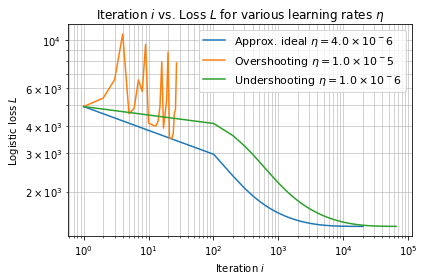

In [676]:
fig = plt.figure()
fig.set_size_inches(6, 4)
plt.plot(*list(np.array(steps[:]).T + 1), label="Approx. ideal $\\eta = 4.0 \\times 10^-6$")
plt.plot(*list(np.array(us_steps[:]).T + 1), label="Overshooting $\\eta = 1.0 \\times 10^-5$")
plt.plot(*list(np.array(os_steps[:]).T + 1), label="Undershooting $\\eta = 1.0 \\times 10^-6$")
# plt.xlim(-1, max(np.hstack([np.array(os_steps).T[1], np.array(us_steps).T[1], np.array(steps).T[1]])))
plt.xscale('log')
plt.yscale('log')
plt.legend(prop={'size': 11})
plt.grid(which='both', alpha=0.7)
plt.xlabel("Iteration $i$")
plt.ylabel("Logistic loss $L$")
plt.title("Iteration $i$ vs. Loss $L$ for various learning rates $\\eta$")
plt.tight_layout()
plt.savefig("graphs/loss_eta.pdf", format='pdf')
plt.show()

In [561]:
# save_ld((steps, us_steps, os_steps), "loss_graph_data")
steps, us_steps, os_steps = load_ld("loss_graph_data")

In [11]:
# Train & save final model for test set prediction
m, n_tr = new_model(X_, Y_, False, X_mr, ci_mr, list(range(len(claims))),
                    eta=4e-6, C=1.127, feat_pc=2, n_pca=4, usampl_ratio=7.5, verbose=True)
n_tr


|  iteration  |   loss   |  accuracy   |   precision   |   recall   |   f1_score   |   f2_score   |
|  0  |  5018.614412213557  |  0.5555262  |  0.2065449  |  0.9775533  |  0.3410337  |  0.5596967  |
|  500  |  1826.8843509724861  |  0.9240724  |  0.8015267  |  0.4713805  |  0.5936396  |  0.5136986  |
|  1000  |  1605.4702047285737  |  0.9247326  |  0.7966728  |  0.4837262  |  0.6019553  |  0.5249695  |
|  1500  |  1523.723126797011  |  0.9260531  |  0.7908612  |  0.5050505  |  0.6164384  |  0.5443987  |
|  2000  |  1480.5830480805112  |  0.9260531  |  0.7819421  |  0.5151515  |  0.6211096  |  0.5528788  |
|  2500  |  1454.1113854885139  |  0.925921  |  0.7759197  |  0.5207632  |  0.6232371  |  0.5574243  |
|  3000  |  1436.47397000755  |  0.9267133  |  0.7790698  |  0.5263749  |  0.6282652  |  0.5628901  |
|  3500  |  1424.0931324525777  |  0.9269774  |  0.7779605  |  0.5308642  |  0.6310874  |  0.5668744  |
|  4000  |  1415.0816758716662  |  0.9269774  |  0.7752443  |  0.5342312  | 

7573

In [12]:
save_ld((m, n_tr), "final_relevance_model.data", pad=False)

In [11]:
save_ld((scores, top_pars, all_pars), "relres_3_732_lidstone_005")
# scores, top_pars, all_pars = load_ld("relevance_results")

In [22]:
save_ld((scores, top_pars, all_pars), "relres_3_1010_dirichlet_0005_cv")

In [34]:
scores, top_pars = load_ld("relevance_results_reldists_ratio")
scores

[[{'usampl_ratio': 4.0}]]

In [13]:
scores, top_pars, all_pars = load_ld("relres_3_1010_dirichlet_0005_cv")
all_pars

[[[({'usampl_ratio': 8.754707249069181},
    (0.49466850020447634,
     0.38613861386138615,
     0.6880569306930694,
     0.3178886323436086,
     0.37355848565625793,
     0.27665926343744857,
     0.2457674655787863,
     0.2771420356526739,
     0.22077416399450298,
     0.24397163120567378,
     0.252076209086468,
     0.2363719651855245)),
   ({'usampl_ratio': 8.140267856586771},
    (0.49184269106342393,
     0.38366336633663367,
     0.6849834983498351,
     0.312174788562223,
     0.3689689642041127,
     0.27053259807343283,
     0.24042713567839194,
     0.2751293847038528,
     0.21349843819723335,
     0.23833955223880599,
     0.24963361016121152,
     0.22802320392681838)),
   ({'usampl_ratio': 8.193017468333876},
    (0.4980573065968106,
     0.3935643564356436,
     0.6780940594059406,
     0.3155947660586836,
     0.3788699543031226,
     0.2704301440608861,
     0.2432992263538807,
     0.28030477285796435,
     0.21492504409171076,
     0.24148319814600233,
     0.2

In [192]:
scores, top_pars, all_pars = load_ld("relres_3_732_dirichlet")
top_pars

[[((0.4008904638589796,
    0.3333333333333333,
    0.5027920227920227,
    0.19907436885458862,
    0.3251548024624948,
    0.1434506481452183,
    0.12180793262700353,
    0.2126007586533902,
    0.08535598705501618,
    0.1258523280732515,
    0.19803801348865727,
    0.09223300970873786),
   {'C': 0.723682436529208, 'usampl_ratio': 3.884710195363176})]]

In [200]:
scores, top_pars, all_pars = load_ld("relres_3_732_lidstone_015")
top_pars

[[((0.41773598311495624,
    0.3452991452991453,
    0.5286324786324786,
    0.21166140229658142,
    0.33323102823102824,
    0.1550836527566838,
    0.13843269591301088,
    0.21395456652758463,
    0.10231681631748142,
    0.1431614827439284,
    0.1991701244813278,
    0.1117392750249418),
   {'C': 1.7009284573978438, 'usampl_ratio': 6.418023264292275}),
  ((0.4028611679729761,
    0.3316239316239316,
    0.513076923076923,
    0.20318462401795737,
    0.3188435638435638,
    0.14909950827217017,
    0.13419131481899602,
    0.20579409048938133,
    0.09955332216638749,
    0.13666453128336536,
    0.18845700824499412,
    0.10720268006700168),
   {'C': -0.4902151795958245, 'usampl_ratio': 6.688013191287546})]]

In [ ]:
np.mean(sum([[t['C'] for t in tp] for tp in top_pars], []))

In [ ]:
top_pars

In [131]:
np.mean([s[0] for s in scores]), np.mean([s[4] for s in scores]), np.mean([s[8] for s in scores])

(0.2427248717630992, 0.4130693069306931, 0.17190429042904293)

In [129]:
np.mean([s[0] for s in scores]), np.mean([s[4] for s in scores]), np.mean([s[8] for s in scores])

(0.25805132823252663, 0.3817821782178218, 0.1949141914191419)

In [105]:
# Reduce unnecessary complexity by finding a threshold distance beyond which we can exclude the samples from training,
# as none of them are relevant, and are therefore unlikely to contribute information to the task of classifying relevant
# sentences at test time (add a small margin based on a fraction of the dataset size to account for the possibility)


In [24]:
i = np.nonzero(np.asarray(Y) == 1)[0][17]
# i = 455
idx_freqs[0][i], all_relsamples[i], res_dists[0, i], rel_data[all_relsamples[i][-2]]

NameError: name 'idx_freqs' is not defined

In [ ]:
# Try to seperate samples by the similarity measure alone (a 1D logistic regression)

In [34]:
from Models import *

In [64]:
m = LR(eta=1e-6, tol=1e-10, no_imp_stop=10, w_init='uniform', print_steps=10)
m.fit(X_train, Y_train)

|  iteration  |  accuracy  |  precision  |  recall  |  f1  |  f2  |
|  0  |  3453877.708596049  |  0.52237  |  0.0046645  |  0.5561097  |  0.0092514  |  0.0225654  |
|  10  |  3453877.7948727496  |  0.97199  |  0.0073892  |  0.0448878  |  0.0126895  |  0.0222772  |
Finished training (no loss improvement for 10 steps)


In [ ]:
# Draw learning curve (accuracy vs number of training datapoints)


In [91]:
x = np.asarray([[2,4],[-3,4],[5,3]])
y = np.array([1,2])
# np.sum(x * y, axis=1) / np.atleast_2d((np.sqrt(np.sum(x ** 2, axis=1)) * np.sqrt(np.sum(y ** 2))))
np.sum(x * y / np.atleast_2d((np.sqrt(np.sum(x ** 2, axis=1)) * np.sqrt(np.sum(y ** 2)))).T, axis=1)

array([1.        , 0.4472136 , 0.84366149])

In [37]:
# Figure out how long we should limit sentences to be when extracting embeddings (some outliers with len >1000 exist)
long_rel = 0
for i in range(len(rel_data)):
    for d_t in rel_data[i]["relevance_samples"]:
        for title, line, relevant in rel_data[i]["relevance_samples"][d_t]:
            if relevant and len(line.split(' ')) > 125:
                long_rel += 1
long_rel

0

In [51]:
claims

[{'id': 75397,
  'verifiable': 'VERIFIABLE',
  'label': 'SUPPORTS',
  'claim': 'Nikolaj Coster-Waldau worked with the Fox Broadcasting Company.',
  'evidence': [[[92206, 104971, 'Nikolaj_Coster-Waldau', 7],
    [92206, 104971, 'Fox_Broadcasting_Company', 0]]],
  'vocab': defaultdict(int,
              {'nikolaj': 1,
               'costerwaldau': 1,
               'worked': 1,
               'with': 1,
               'the': 1,
               'fox': 1,
               'broadcasting': 1,
               'company': 1})},
 {'id': 150448,
  'verifiable': 'VERIFIABLE',
  'label': 'SUPPORTS',
  'claim': 'Roman Atwood is a content creator.',
  'evidence': [[[174271, 187498, 'Roman_Atwood', 1]],
   [[174271, 187499, 'Roman_Atwood', 3]]],
  'vocab': defaultdict(int,
              {'roman': 1,
               'atwood': 1,
               'is': 1,
               'a': 1,
               'content': 1,
               'creator': 1})},
 {'id': 214861,
  'verifiable': 'VERIFIABLE',
  'label': 'SUPPORTS',
  '

In [64]:
# Retrieve top-5 similar documents using Laplace smoothing with Lidstone correction (using epsilon=0.05)
res = eval_model(lidstone_ll, epsilon=0.05, claims_=claims)
acc = res[0]
print(acc)
pr(res[1])

Computing similarities...
Batches: 540


[Parallel(n_jobs=96)]: Using backend LokyBackend with 96 concurrent workers.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=96)]: Done  96 tasks      | elapsed:  6.7min
[Parallel(n_jobs=96)]: Done 258 tasks      | elapsed: 11.6min
[Parallel(n_jobs=96)]: Done 458 out of 540 | elapsed: 17.8min remaining:  3.2min
[Parallel(n_jobs=96)]: Done 540 out of 540 | elapsed: 20.1min finished


Ranking documents...
Evaluating accuracy...
0.25666666666666665
[   [   (-88.32562602513612, 'Glossary_of_sumo_terms'),
        (-87.53034574001876, 'List_of_books_by_Jacob_Neusner'),
        (-87.09446736251365, 'List_of_video_game_crowdfunding_projects'),
        (-85.96664404030582, 'List_of_Latin_legal_terms'),
        (-85.88756594576691, 'List_of_songs_about_Paris')],
    [   (-113.69317923324901, 'Kanye_West_discography'),
        (-113.54722278740641, 'Outkast_discography'),
        (-110.87900565825775, 'Beyoncé_discography'),
        (-108.62218353065947, 'Ricky_Martin_singles_discography'),
        (-102.18636581560878, 'Snoop_Dogg_discography')],
    [   (-69.90791042003866, 'Alma_Ziegler'),
        (-69.85513001771425, 'Timeline_of_San_Bernardino,_California_history'),
        (-69.38033061091798, 'List_of_video_game_crowdfunding_projects'),
        (-68.90621816887726, 'Science_and_technology_in_Venezuela'),
        (-68.33329707121771, 'Wally_Donald')],
    [   (-97.3246

In [65]:
len(res[1])

100

In [132]:
similarities = [jm_ll(*wiki[doc_id]) for doc_id in D_ids]
print("Ranking documents...")
top_docs = []
for i in range(N_claims):
    sims = [(similarities[j][i], D_ids[j]) for j in range(N_docs)]
    sims.sort()
    top_docs.append(sims[-5:])
top_docs_ids = [[s[1] for s in s_] for s_ in top_docs]
print("Evaluating accuracy...")
recall = [np.mean([
    id_ in top_docs_ids[i] for id_ in set([s[2] for s in sum(claims[i]["evidence"], [])])]) \
                  for i in range(len(claims))]
np.mean(recall), top_docs

wat defaultdict(<class 'int'>, {'hunger': 0})


ZeroDivisionError: float division by zero

In [88]:
claims

[{'id': 75397,
  'verifiable': 'VERIFIABLE',
  'label': 'SUPPORTS',
  'claim': 'Nikolaj Coster-Waldau worked with the Fox Broadcasting Company.',
  'evidence': [[[92206, 104971, 'Nikolaj_Coster-Waldau', 7],
    [92206, 104971, 'Fox_Broadcasting_Company', 0]]],
  'vocab': defaultdict(int,
              {'nikolaj': 1,
               'costerwaldau': 1,
               'worked': 1,
               'with': 1,
               'the': 1,
               'fox': 1,
               'broadcasting': 1,
               'company': 1})},
 {'id': 150448,
  'verifiable': 'VERIFIABLE',
  'label': 'SUPPORTS',
  'claim': 'Roman Atwood is a content creator.',
  'evidence': [[[174271, 187498, 'Roman_Atwood', 1]],
   [[174271, 187499, 'Roman_Atwood', 3]]],
  'vocab': defaultdict(int,
              {'roman': 1,
               'atwood': 1,
               'is': 1,
               'a': 1,
               'content': 1,
               'creator': 1})},
 {'id': 214861,
  'verifiable': 'VERIFIABLE',
  'label': 'SUPPORTS',
  '

In [13]:
claim_ids = [75397, 150448, 214861, 156709, 129629, 33078, 6744, 226034, 40190, 76253]
claims = []
claims_vocab = set()
with open(data_dir + "train.jsonl", 'r') as f:
    a = jsonlines.Reader(f)
    for a_ in a:
        if a_["id"] in claim_ids:
            claims.append(a_)
            claims[-1]["vocab"] = defaultdict(int)
            for w in a_["claim"].replace('-LRB-', '').replace('-RRB-', '').replace("'s", ''). \
              translate(punc_trans).lower().split():
                claims[-1]["vocab"][w] += 1
                claims_vocab.add(w)

In [15]:
N_docs = 0
n_t = defaultdict(int)
i_ = 0
for fn in fs:
    with open(fn, 'r') as f:
        a = jsonlines.Reader(f)
        for a_ in a:
            if a_["id"] == "":
                continue
            N_docs += 1
            entry = [[w.translate(punc_trans).lower() for w in l.split()[1:] if w != \
                     '' and not ((any(c.isnumeric() for c in w) and len(w) > 7) or \
                                 (w.isnumeric() and len(w) > 5))] for l in a_[
                    "lines"].replace('-LRB-', '').replace('-RRB-', '').replace("'s", '').split('\n') if \
                     len(l) > 0 and not (len(l) == 1 and l[0].isnumeric())]
            for w in set(sum(entry, [])):
                if w in claims_vocab:
                    n_t[w] += 1
    i_ += 1
    sys_print("\r" + str(i_))
N_docs

109

5416536

In [19]:
# Load each document and measure cosine similarity
similarities = {}
i_ = 0
for fn in fs:
    with open(fn, 'r') as f:
        a = jsonlines.Reader(f)
        for a_ in a:
            if a_["id"] == "":
                continue
            doc_tf = defaultdict(int)
            for l in ([w.translate(punc_trans).lower() for w in l.split()[1:] if w != \
                     '' and not ((any(c.isnumeric() for c in w) and len(w) > 7) or \
                                 (w.isnumeric() and len(w) > 5))] for l in a_[
                    "lines"].replace('-LRB-', '').replace('-RRB-', '').replace("'s", '').split('\n') if \
                     len(l) > 0 and not (len(l) == 1 and l[0].isnumeric())):
                for w in l:
                    if w in claims_vocab:
                        doc_tf[w] += 1
            doc_tf = {w: doc_tf[w] * np.log(N_docs / n_t[w]) for w in doc_tf}
            similarities[a_["id"]] = [sum([doc_tf[w] for w in claim["vocab"] if w in doc_tf]) for claim in claims]
    i_ += 1
    sys_print("\r" + str(i_))
similarities = list(similarities.items())

109

In [22]:
top_docs = []
for i in range(10):
    sims = [(s[1][i], s[0]) for s in similarities]
    sims.sort()
    top_docs.append(sims[-5:])
top_docs

[[(566.179224990433, 'List_of_New_Jersey_street_railroads'),
  (579.0265022006889,
   'List_of_early_British_private_locomotive_manufacturers'),
  (580.2826817534418, 'List_of_OMIM_disorder_codes'),
  (920.8325654914589, 'Mottos_and_halls_of_the_Livery_Companies'),
  (1122.7571604226562, 'Pteropodinae')],
 [(236.04509710808153, 'History_of_the_Roman_Constitution'),
  (248.6656867489665, 'List_of_New_Zealand_religious_leaders'),
  (322.341723583277, 'List_of_New_Zealand_Catholic_bishops'),
  (331.034077391518, 'List_of_Catholic_schools_in_New_York'),
  (665.3830074019156, 'History_of_Rome_-LRB-disambiguation-RRB-')],
 [(943.9322647631498, 'Western_literature'),
  (1089.2646242221958, 'List_of_New_Music_America_performances'),
  (1261.5168052555575, 'List_of_national_theatres'),
  (1418.3355392869555, 'List_of_books_by_Jacob_Neusner'),
  (1574.613579602451,
   'List_of_artists_in_the_Philadelphia_Museum_of_Art_handbook_of_the_collections')],
 [(127.08135108472278, 'List_of_This_Is_Daniel

In [26]:
# Query-likelihood unigram language modelling (unsmoothed)
def prod(xs):
    if len(xs) == 0:
        return 0
    if len(xs) > 1:
        return xs[0] * prod(xs[1:])
    return xs[0]
likelihoods = {}
i_ = 0
for fn in fs:
    with open(fn, 'r') as f:
        a = jsonlines.Reader(f)
        for a_ in a:
            if a_["id"] == "":
                continue
            doc_M = defaultdict(int)
            total = 0
            for l in ([w.translate(punc_trans).lower() for w in l.split()[1:] if w != \
                     '' and not ((any(c.isnumeric() for c in w) and len(w) > 7) or \
                                 (w.isnumeric() and len(w) > 5))] for l in a_[
                    "lines"].replace('-LRB-', '').replace('-RRB-', '').replace("'s", '').split('\n') if \
                     len(l) > 0 and not (len(l) == 1 and l[0].isnumeric())):
                for w in l:
                    if w in claims_vocab:
                        doc_M[w] += 1
                    total += 1
            doc_M = {w: doc_M[w] / total for w in doc_M}
            likelihoods[a_["id"]] = [prod([doc_M[w] for w in claim["vocab"] if w in doc_M]) for claim in claims]
    i_ += 1
    sys_print("\r" + str(i_))
likelihoods = list(likelihoods.items())

109

In [27]:
top_docs_us = []
for i in range(10):
    sims = [(s[1][i], s[0]) for s in likelihoods]
    sims.sort()
    top_docs_us.append(sims[-5:])
top_docs_us

[[(0.34615384615384615, 'The_Last_of_the_Jedi-COLON-_Against_the_Empire'),
  (0.35714285714285715, 'The_Glitterati_-LRB-album-RRB-'),
  (0.36363636363636365, 'The_Kabeedies_discography'),
  (0.375, 'On_air'),
  (0.38461538461538464, 'Public_holidays_in_the_Bahamas')],
 [(0.2857142857142857, 'List_of_fictional_alien_species-COLON-_A'),
  (0.3157894736842105, 'C30H50O4'),
  (0.3333333333333333, 'List_of_Members_of_the_Canadian_Senate_-LRB-A-RRB-'),
  (0.3333333333333333, 'Purpuric_acid'),
  (0.3333333333333333, 'Reem_-LRB-given_name-RRB-')],
 [(0.40625, 'Portuguese-language_literature'),
  (0.41935483870967744, 'East_Asian_poetry'),
  (0.42857142857142855, 'Arts_by_region'),
  (0.4523809523809524, 'Yugoslav_literature'),
  (0.5, 'Testament_of_Qahat')],
 [(0.25, 'Diosmetinidin'),
  (0.25, 'Ruether'),
  (0.2608695652173913, 'List_of_DC_Comics_characters-COLON-_K'),
  (0.3333333333333333, 'Purpuric_acid'),
  (0.3333333333333333, 'Reem_-LRB-given_name-RRB-')],
 [(0.373134328358209, 'Constitu

In [47]:
# Import wikipedia dataset document word counts for the claim vocabulary
wiki = {}
i_ = 0
for fn in fs:
    with open(fn, 'r') as f:
        a = jsonlines.Reader(f)
        for a_ in a:
            if a_["id"] == "":
                continue
            doc_M = defaultdict(int)
            total = 0
            for l in ([w.translate(punc_trans).lower() for w in l.split()[1:] if w != \
                     '' and not ((any(c.isnumeric() for c in w) and len(w) > 7) or \
                                 (w.isnumeric() and len(w) > 5))] for l in a_[
                    "lines"].replace('-LRB-', '').replace('-RRB-', '').replace("'s", '').split('\n') if \
                     len(l) > 0 and not (len(l) == 1 and l[0].isnumeric())):
                for w in l:
                    if w in claims_vocab:
                        doc_M[w] += 1
                    total += 1
            wiki[a_["id"]] = doc_M, total
    i_ += 1
    sys_print("\r" + str(i_))
N_docs = len(wiki)
N_docs

5416536

In [49]:

top_docs_ls

[[(-93.88792155564518, 'Peter_Windsor'),
  (-93.3362426640573, 'Mike_Darnell'),
  (-93.2490523905636, "List_of_Bob's_Burgers_episodes"),
  (-93.14458474306068, 'Jimmy_Hodson'),
  (-92.12060364493253, 'Joel_Cheatwood')],
 [(-71.50651994917307, 'Ríos'),
  (-71.29546258204249, 'Giancarlo_Volpe'),
  (-70.35450291570794, 'List_of_essential_oils'),
  (-67.08361379838946, 'List_of_Latin_legal_terms'),
  (-64.71084161996984, 'List_of_video_game_crowdfunding_projects')],
 [(-212.1720252860265, 'List_of_New_Music_America_performances'),
  (-211.8780699805498, 'Narrative'),
  (-211.516743391354, 'List_of_Guggenheim_Fellowships_awarded_in_1968'),
  (-209.68037646198567, 'Acropolis_Institute_of_Technology_and_Research'),
  (-190.23549854041386, 'History_of_art')],
 [(-60.642762136163455, 'Loni_Love'),
  (-60.63228118073983, 'Jeannie_Mai'),
  (-60.41817178428785, 'Roy_"Royalty"_Hamilton'),
  (-60.251009380271654, 'Tamar_Braxton'),
  (-59.94750735936245, 'Adrienne_Bailon')],
 [(-169.6512907398757, 'L

0.75

In [31]:
claims

[{'id': 75397,
  'verifiable': 'VERIFIABLE',
  'label': 'SUPPORTS',
  'claim': 'Nikolaj Coster-Waldau worked with the Fox Broadcasting Company.',
  'evidence': [[[92206, 104971, 'Nikolaj_Coster-Waldau', 7],
    [92206, 104971, 'Fox_Broadcasting_Company', 0]]],
  'vocab': defaultdict(int,
              {'nikolaj': 1,
               'costerwaldau': 1,
               'worked': 1,
               'with': 1,
               'the': 1,
               'fox': 1,
               'broadcasting': 1,
               'company': 1})},
 {'id': 150448,
  'verifiable': 'VERIFIABLE',
  'label': 'SUPPORTS',
  'claim': 'Roman Atwood is a content creator.',
  'evidence': [[[174271, 187498, 'Roman_Atwood', 1]],
   [[174271, 187499, 'Roman_Atwood', 3]]],
  'vocab': defaultdict(int,
              {'roman': 1,
               'atwood': 1,
               'is': 1,
               'a': 1,
               'content': 1,
               'creator': 1})},
 {'id': 214861,
  'verifiable': 'VERIFIABLE',
  'label': 'SUPPORTS',
  '

In [ ]:
# Evaluate distances
arg_min_idx = 3    # Minimum index into the sentence to end truncation for minimising distance to query (experimental)
res = np.empty((len(dist_funcs), len(all_relsamples), 1024))
i_ = -1
idx_freqs = [[] for _ in range(len(dist_funcs))]
for j in range(n_elmo_bats):
    rel_bat = all_relsamples[j * elmo_bsize:(j + 1) * elmo_bsize]
    elmo_samples = load_ld("H:\Code\IR\data\learning_data\elmo_res_" + str(j) + ".data", pad=False)
#     pr(elmo_samples[0])
#     break
    for i in range(elmo_samples.shape[0]):
        i_ += 1
#         print(rel_data[rel_bat[i][4]]["claim"])
#         print(rel_bat[i][1])
        query_elmo = query_elmos[rel_bat[i][4]]
        elmo_sample = elmo_samples[i]
        elmo_comps = [eval_comps(elmo_sample, f, query_elmo) for (_, f) in dist_funcs]
        elmo_dists = [eval_dists(elmo_comps[k], dist_funcs[k][0]) for k in range(len(dist_funcs))]
        n_words = rel_bat[i][5]
        title_len = len(rel_bat[i][0].split(' '))
        min_idx = max(min(title_len + arg_min_idx + 1, n_words - 2), 0)
        for k in range(len(dist_funcs)):
#             print(elmo_dists[k].round(3))
#             print((n_words - 1,
#                     max(title_len + arg_min_idx + 1, 
#                     np.argmin(elmo_dists[k]))))
#             if min_idx >= n_words - 1:
#                 print(rel_data[rel_bat[i][4]]["claim"])
#                 print(rel_bat[i][0], rel_bat[i][1])
#                 print(elmo_dists[k])
#                 print(min_idx, n_words - 1)
#             try:
            idx = min_idx + np.argmin(elmo_dists[k][min_idx:max(n_words - 1, 1)])
#             except:
#                 print(rel_data[rel_bat[i][4]]["claim"])
#                 print(rel_bat[i][0], ' : ', rel_bat[i][1])
#                 print(elmo_dists[k])
#                 print(min_idx, n_words - 1)
#                 print("Unexpected error:", sys.exc_info()[0])
#                 raise
#             print(idx, elmo_dists[k][idx])
#             print(n_words - 1 == idx)
            idx_freqs[k].append((n_words, idx))
#             if not n_words - 1 == idx:
#             if True:
#                 print(rel_data[rel_bat[i][4]]["claim"])
#                 print(rel_bat[i][1])
#                 print(elmo_dists[k])
#                 print(idx, elmo_dists[k][idx])
#                 print(np.argmin(elmo_dists[k]), elmo_dists[k][np.argmin(elmo_dists[k])])
#                 print(elmo_dists[k][idx])
#                 print(elmo_comps[k][idx])
#                 print(sum(elmo_comps[k][idx]))
#                 sys.exit()
            res[k, i_] = elmo_comps[k][idx]
    del elmo_samples
    gc.collect()
    sys_print("\rBatch " + str(j + 1) + '/' + str(n_elmo_bats) + '     ')

In [167]:
query_incl_fstop = True   # Whether to include the fullstop at the end of the claim
query_use_mean = False          # Whether to use the mean of the words rather than the last word
query_model = True      # Whether to weight words according to probability of occuring in the specific query
def rem_fullstop(x):
    return x[:-1].strip() if x[-1] == '.' and not query_incl_fstop else x
query_elmos = []
n_batches = 8
for i in range(n_batches):
    i_, i__ = i * (len(rel_data) // n_batches), ((i + 1) * (len(rel_data) // n_batches)) if i < n_batches - 1 else len(rel_data)
    ix = [len(rem_fullstop(claim["relevance_claim"]).split(' ')) - (0 if query_use_mean else 1) for claim in rel_data[i_:i__]]
    xs = elmo_vectors([rem_fullstop(claim["relevance_claim"]) for claim in rel_data[i_:i__]])
    query_elmos += [np.vstack([np.mean(xs[j, :ix[j]], axis=0) for j in range(len(xs))]) if query_use_mean else \
                    xs[range(len(xs)), ix]]
    sys_print("\r" + str(i + 1) + '/' + str(n_batches))
query_elmos = np.vstack(query_elmos)
# from sklearn.linear_model import *
#             [("model", LogisticRegression(C=10.0 ** C, penalty='l2', solver="liblinear"))])

8/8

In [252]:
scores, top_pars, all_pars, all_probs = relevance_evaluation(optimise_C=False,  # Test best n-D LR (3075-D; all features)
      optimise_eta=False, optimise_feat_pc=False, optimise_n_pca=False, optimise_ratio=False, optimise_proximity=False,
      C=1.127, feat_pc=2, n_pca=4, usampl_ratio=7.5, n_reps=10, cv_k=10)

Run 1 Fold 1/10     Press Enter to continue, 's' to stop, 'f' to automate: f
Run 1 Fold 2/10     Run 1 Fold 3/10     Run 1 Fold 4/10     Run 1 Fold 5/10     Run 1 Fold 6/10     Run 1 Fold 7/10     Run 1 Fold 8/10     Run 1 Fold 9/10     Run 1 Fold 10/10     (0.5030983797774532, 0.39900990099009903, 0.6806600660066007, 0.31736479559720143, 0.383979980415624, 0.2704461507808788, 0.20900317460317464, 0.26910279991825053, 0.17084728169196836, 0.20914624629311693, 0.24479356960175375, 0.18256130790190736)
Run 2 Fold 1/10     Run 2 Fold 2/10     Run 2 Fold 3/10     Run 2 Fold 4/10     Run 2 Fold 5/10     Run 2 Fold 6/10     Run 2 Fold 7/10     Run 2 Fold 8/10     Run 2 Fold 9/10     Run 2 Fold 10/10     (0.5032184998699132, 0.4, 0.6782343234323432, 0.3190044266117886, 0.38612169458704115, 0.2717650951448861, 0.21426484282182193, 0.27275086858777847, 0.17643240527749138, 0.2139138665404638, 0.24771647789550602, 0.18822876179900055)
Run 3 Fold 1/10     Run 3 Fold 2/10     Run 3 Fold 3/10     R